In [8]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from pysankey import sankey
from math import pi
import scipy.stats as ss
import matplotlib.dates as mdates
from age_gender_distribution_distances import *
import git
import os
from statsmodels.stats import multitest as multitest
import pickle as pkl

sns.set_theme(style="whitegrid", font_scale=3)

import matplotlib

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 


## Data initialization

In [9]:
# Define some basic variables
path_figures = "../../Doc/WWW24/Figures/"

# Define party order
party_order = ["linke", "gruene", "spd", "fdp", "union", "afd"]
# Define party labels
party_labels = {"linke": "Linke", "gruene": "Grüne", "spd": "SPD" , "fdp": "FDP", "union": "Union", "afd": "AfD"}
# Define color palette
party_pal = {"spd": "#E3000F", "union": "#222222", "gruene": "#46962B", "fdp": "#FFED00", "afd": "#009EE0", "linke": "#990099"}

# old linke --> #B61C3E

# Party mapping
party_mapping = {
    "The Left (Germany)": "linke",
    "Green party": "gruene",
    "Alliance '90/The Greens": "gruene",
    "Social Democratic Party of Germany": "spd",
    "Young Socialists in the SPD": "spd",
    "FDP.The Liberals": "fdp",
    "Free Democratic Party (Germany)": "fdp",
    "CDU/CSU": "union",
    "Christian Democratic Union (Germany)": "union",
    "Christian Social Union in Bavaria": "union",
    "Alternative fÃ¼r Deutschland AfD": "afd"
}


In [10]:
# Importing the dataset
df = pd.read_csv("../../Data/DE_merged_data.csv")

# df = df[df["spend"] != "False"]
# df["spend"] = df["spend"].astype(float)
# df["impressions"] = df["impressions"].astype(float)
# df["impressions_per_spending"] = df["impressions_per_spending"].astype(float)

# df = df.replace("False", False)
# df = df.replace(True, True)
# df["exclude_location"] = [True if d == "1.0" else False for d in df["exclude_location"]]
# df = df.drop("include_location", axis=1)

# Filter relevant data
df = df.loc[df["party"] != "others"]

# # Converting the exclude_location column
# df["exclude_location"] = [True if ex_loc == 1 else False for ex_loc in df["exclude_location"]] 

# # Dropping redundant columns used for the prediction model
# for c in df.columns:
#     if "use" in c or 'count' in c:
#         # print(c)
#         df = df.drop(c, axis=1)

print("Number of ads:")
print(df.__len__())

Number of ads:
81549


/var/folders/b1/rdb8b9050b5_6qc4tjvfdpc80000gn/T/ipykernel_43571/2499114522.py:2: DtypeWarning: Columns (18,24,37,53,54,59,63,68,72,73,74,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../Data/DE_merged_data.csv")


## Stats on the dataset

81549.0
9809553.86038028
1156496450.1646042
\begin{tabular}{lrrr}
\toprule
party & count & spend & impressions \\
\midrule
afd & 2487 & 577429 & 87361955 \\
fdp & 10327 & 1369329 & 319367015 \\
gruene & 38604 & 3608103 & 205728143 \\
linke & 2257 & 390950 & 75087865 \\
spd & 12525 & 1526741 & 169188312 \\
union & 15349 & 2337002 & 299763160 \\
\bottomrule
\end{tabular}



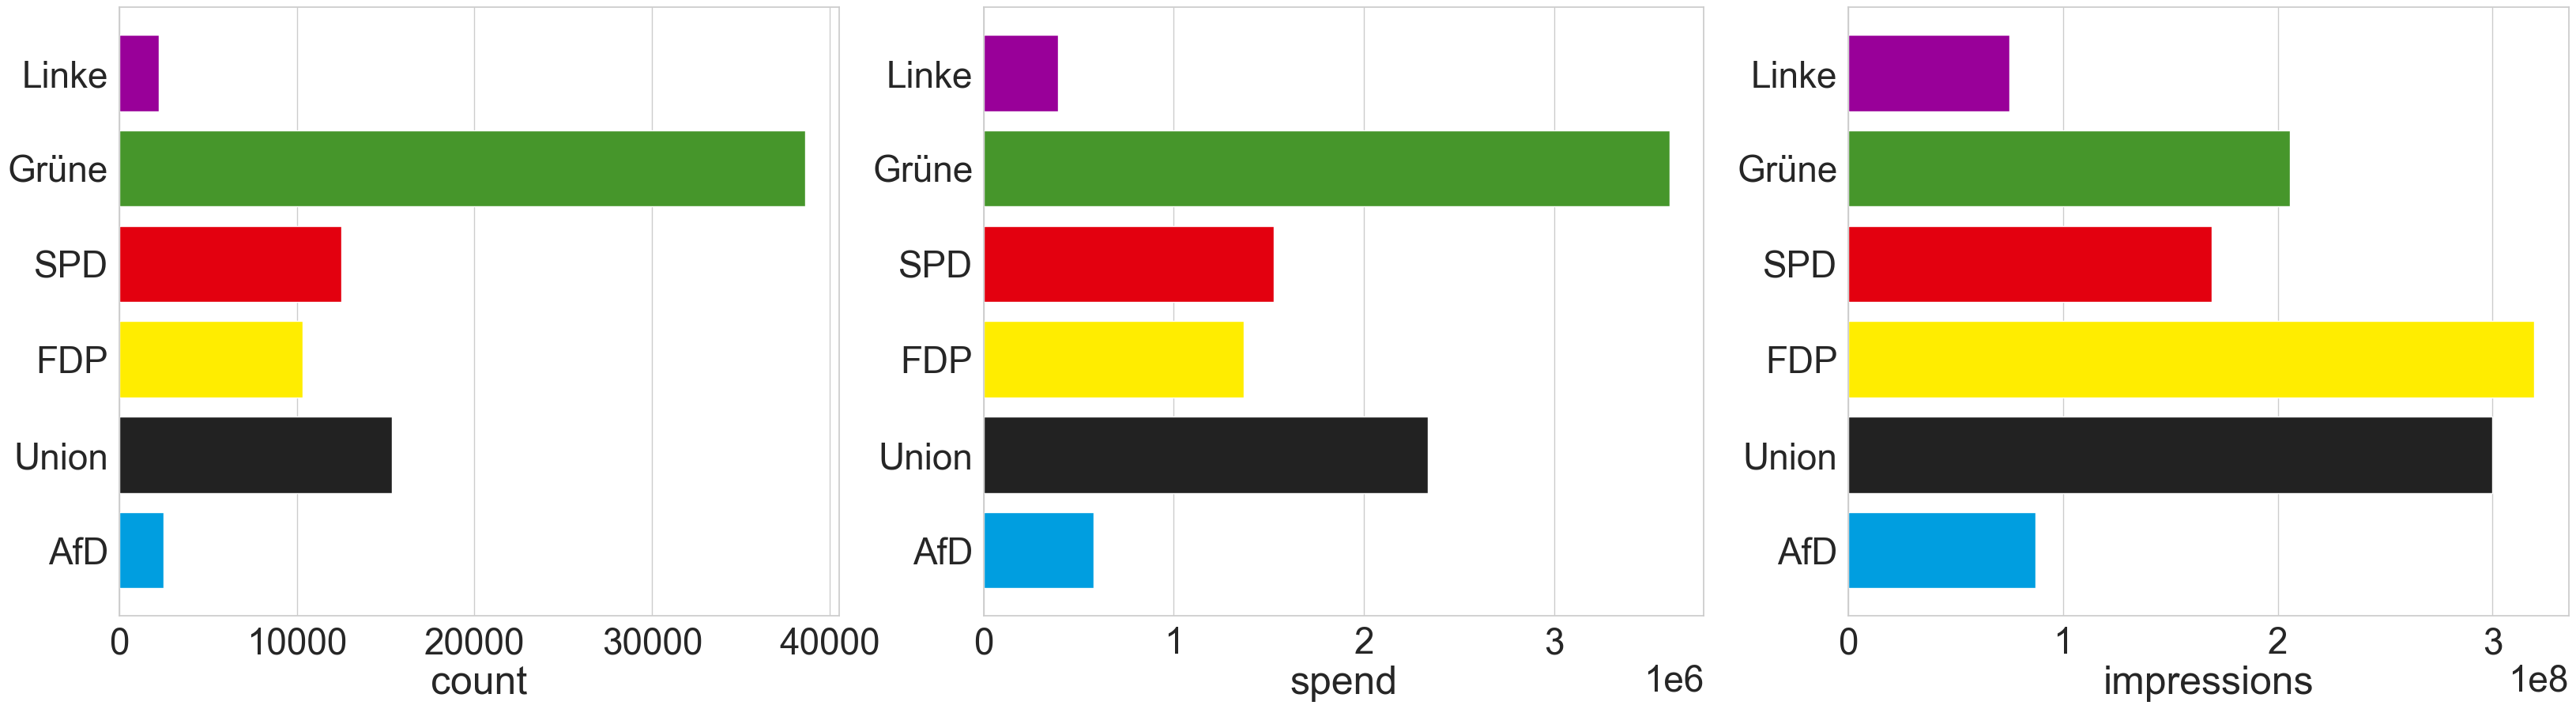

In [11]:
count_money_impressions = dict()
for party, d in df.groupby("party"):
    count_money_impressions[party] = {'count':d.__len__(), 'spend':d["spend"].sum(), 'impressions':d["impressions"].sum()}

stats_df = pd.DataFrame(count_money_impressions).T.reset_index(names='party')

print(stats_df["count"].sum())
print(stats_df["spend"].sum())
print(stats_df["impressions"].sum())

# Set up the plot
fig, axs = plt.subplots(1, 3, figsize=(40, 10))
i = 0
for col in ["count", "spend", "impressions"]:
    categories = party_order[::-1]
    values = [count_money_impressions[c][col] for c in categories]
    labels = [party_labels[p] for p in party_order[::-1]]
    ax = axs[i]
    # Plot the horizontal bars
    bars = ax.barh(labels, values, color=[party_pal[p] for p in categories])

    # Customize the plot
    ax.set_xlabel(col)
    ax.set_ylabel('')

    # Add vertical grid lines
    ax.grid(axis='y')
    i += 1

# Print latex table for the paper
print(stats_df.to_latex(index=False,
                   formatters={"name": str.upper},
                   float_format="{:.0f}".format))

## Time series figure

/var/folders/b1/rdb8b9050b5_6qc4tjvfdpc80000gn/T/ipykernel_43571/1598616373.py:23: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ax.axvline(pd.to_datetime("26/09/2021"), ls="--", color="black", linewidth=4)


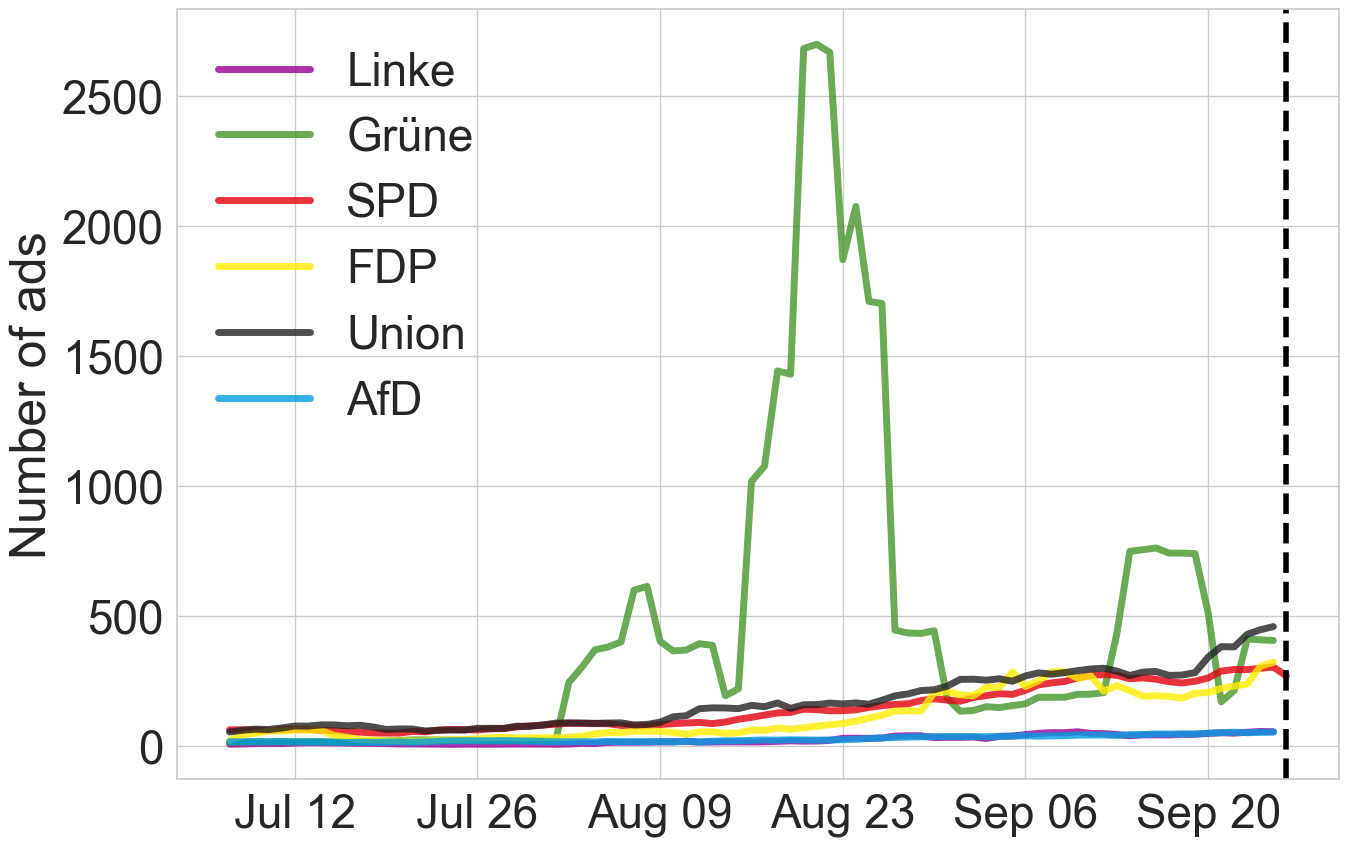

In [12]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15, 10))

# Counting the number of ads created in each day
ts = df.groupby(["party", "ad_delivery_start_time"]).count().reset_index()[["ad_delivery_start_time", "party", "13-17"]]
ts["ad_delivery_start_time"] = pd.to_datetime(ts["ad_delivery_start_time"])

# ts = ts[ts["ad_delivery_start_time"] < "2021-09-25"]
# sns.lineplot(x="ad_delivery_start_time", y="13-17", hue="party", ls="", marker="o", alpha=0.5, palette=party_pal, data=ts)

for ix in party_order:
    ts_p = ts[ts["party"] == ix]
    ts_p = pd.Series(ts_p["13-17"].values, ts_p["ad_delivery_start_time"])
    # ax.plot(ts_p, ls="-", marker="", linewidth=2, alpha=0.2, color=party_pal[ix])
    ## computing 7-day moving average
    ts_p = ts_p.rolling(window=7).mean()
    ax.plot(ts_p, ls="-", marker="", linewidth=5, alpha=0.8, color=party_pal[ix], label= party_labels[ix])
    # ts_std = ts_p.rolling(window=7).std()
    # y2 = ts_p + ts_std
    # y1 = ts_p - ts_std
    # ax.fill_between(x = y1.index, y1 = y1, y2 = y2, alpha=0.2, color=party_pal[ix])
# ts.rolling(window=7, on="ad_delivery_start_time")

ax.axvline(pd.to_datetime("26/09/2021"), ls="--", color="black", linewidth=4)
ax.set_xlabel("")
ax.set_ylabel("Number of ads")
ax.legend(frameon=False)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
fig.savefig(path_figures+"time_series_ads.pdf")

## Efficiency figures

In [13]:

# Summary statistics per party
df_party = df.groupby("party").agg({"impressions_per_spending": ["min", "max", "mean", "median", "std"]})

# Test group differences

# Kruskal-Wallis test
for party in party_order:
    print(party)
    print(sp.stats.kruskal(df["impressions_per_spending"].loc[df["party"] == party], df["impressions_per_spending"].loc[df["party"] != party], nan_policy="omit"))
    print("\n")
    
# All parties significantly different form others

# Mann-Whitney U test
for party in party_order:
    print(party)
    print(sp.stats.mannwhitneyu(df["impressions_per_spending"].loc[df["party"] == party], df["impressions_per_spending"].loc[df["party"] != party], nan_policy="omit"))
    print("\n")

# All parties significantly different form others

linke
KruskalResult(statistic=605.3524871155465, pvalue=1.1470940589056225e-133)


gruene
KruskalResult(statistic=16186.007863638983, pvalue=0.0)


spd
KruskalResult(statistic=2245.4911902400218, pvalue=0.0)


fdp
KruskalResult(statistic=3301.8425625765867, pvalue=0.0)


union
KruskalResult(statistic=1669.9080010568357, pvalue=0.0)


afd
KruskalResult(statistic=1810.9007138480567, pvalue=0.0)


linke
MannwhitneyuResult(statistic=115010270.5, pvalue=1.1471076814007167e-133)


gruene
MannwhitneyuResult(statistic=427137529.5, pvalue=0.0)


spd
MannwhitneyuResult(statistic=540331022.0, pvalue=0.0)


fdp
MannwhitneyuResult(statistic=488626809.0, pvalue=0.0)


union
MannwhitneyuResult(statistic=609086170.5, pvalue=0.0)


afd
MannwhitneyuResult(statistic=144596704.5, pvalue=0.0)




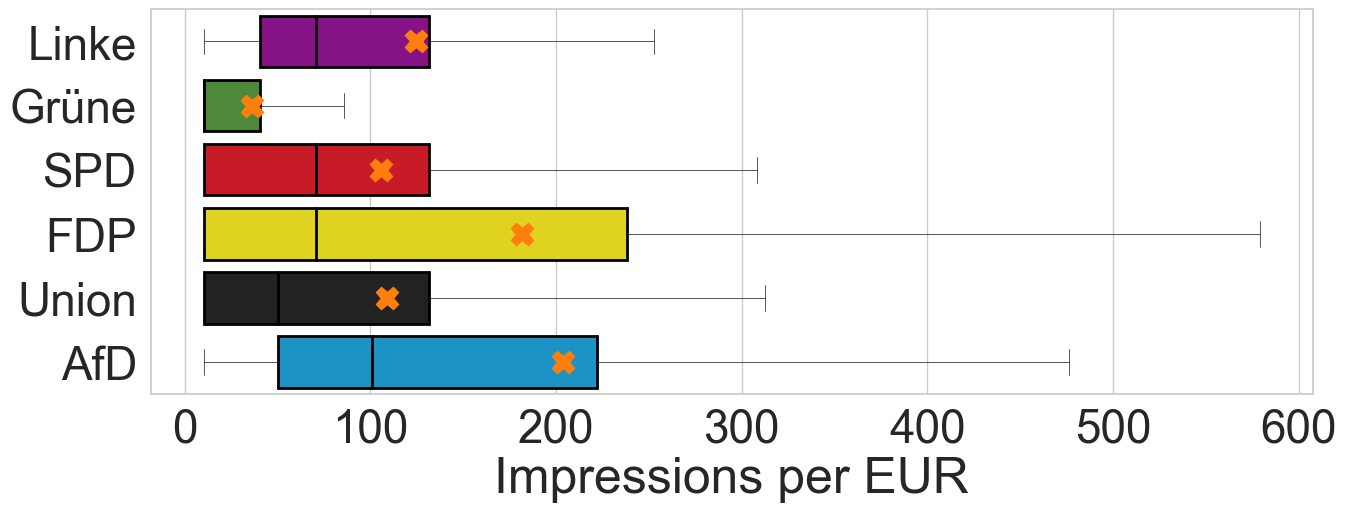

In [14]:
# df_jitter = df.loc[df["impressions_per_spending"] < np.quantile(df["impressions_per_spending"], 0.95)]

# Scatterplot
# sns.stripplot(data=df_jitter, x='impressions_per_spending', y='party', alpha=0.05, palette=party_pal, order=party_order)

plt.figure(figsize=(15, 5))
# Boxplot
sns.boxplot(data=df, x="impressions_per_spending", y="party", showfliers=False, showmeans=True, linewidth=0.5, 
            palette=party_pal, order=party_order,
            meanprops={"marker":"X",
                       "markerfacecolor":"tab:orange", 
                       "markeredgecolor":"tab:orange",
                       "markersize":"16",
                       },
            medianprops={'linewidth':2, 'color':'black'},
            boxprops = {"linewidth":2, 'edgecolor':'black'})


plt.yticks(ticks=[0, 1, 2, 3, 4, 5], labels=party_labels.values())
plt.xlabel("Impressions per EUR")
plt.ylabel("")
plt.savefig(path_figures + "efficiency_party.pdf")
plt.show()

86.50309387588639
[ 76.77496046 -17.75111523  54.8176919  -21.02788632 -90.53532122
  -2.2783296 ]


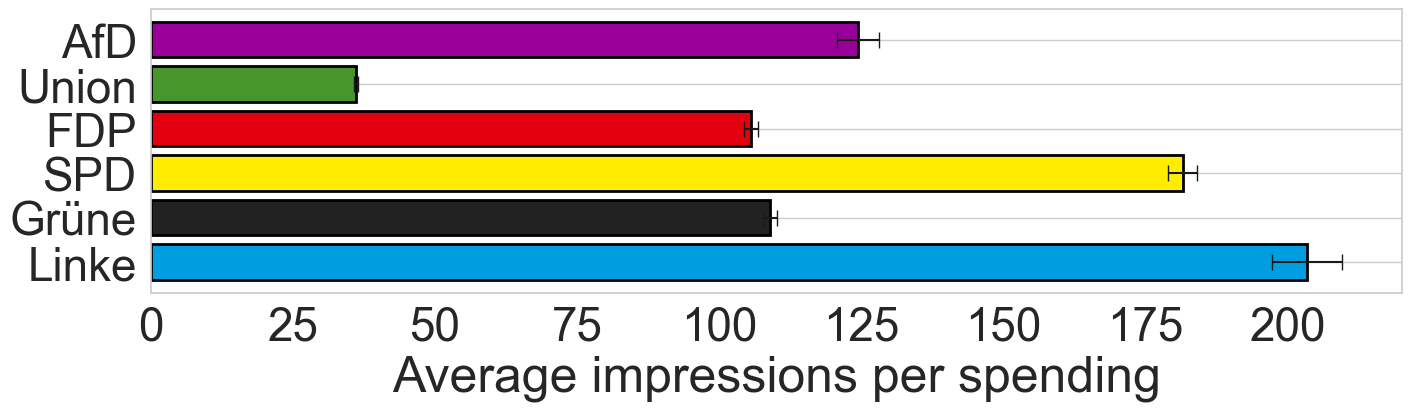

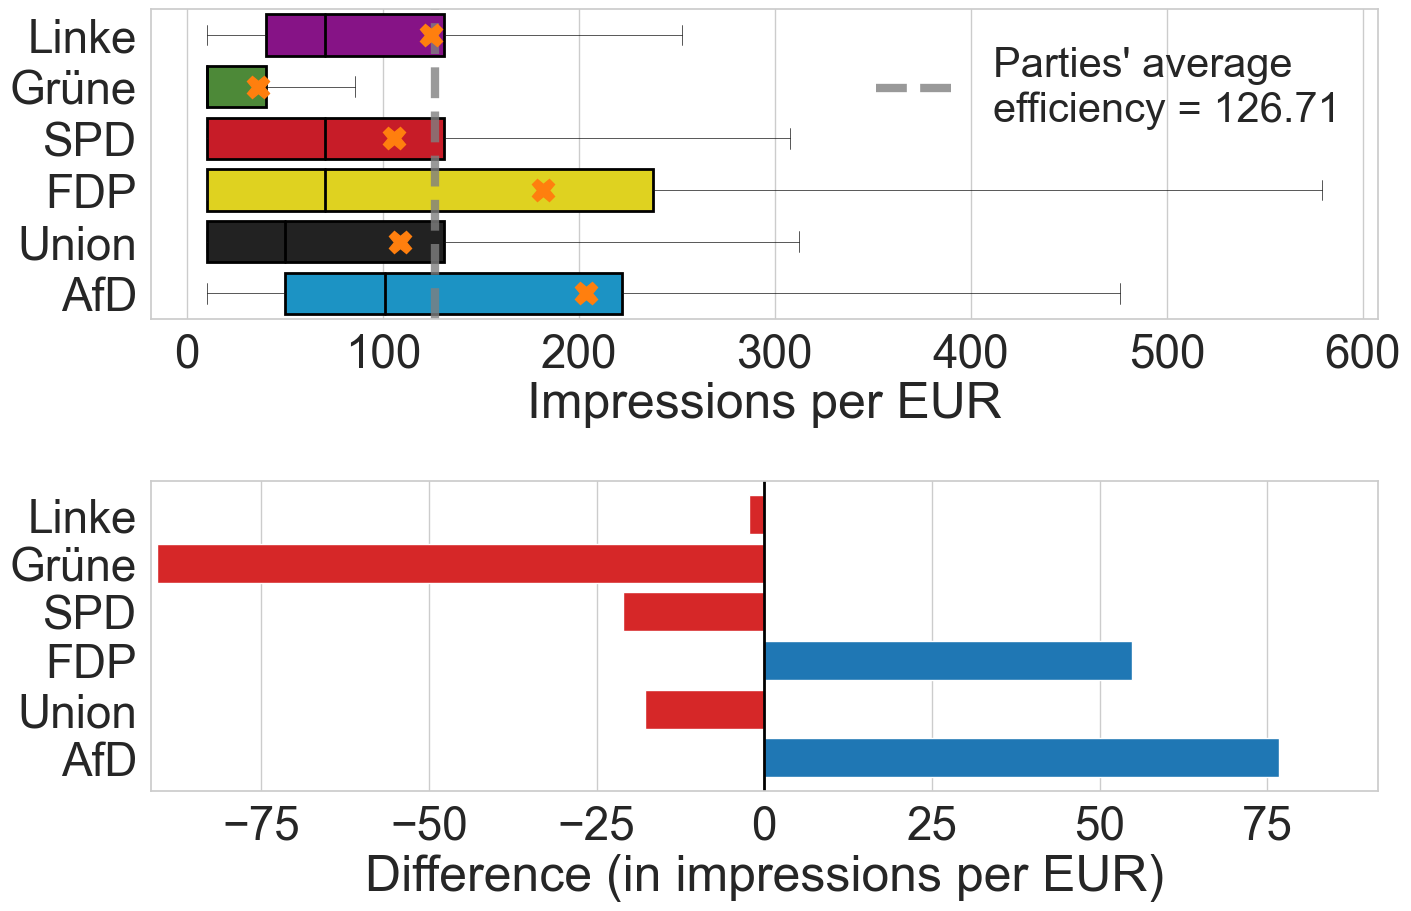

In [15]:

categories = party_order[::-1]
sem_values = np.array([ss.sem(df[df["party"] == k]["impressions_per_spending"]) for k in categories])

print(np.mean(df["impressions_per_spending"]))
values = np.array([np.mean(df[df["party"] == k]["impressions_per_spending"]) for k in categories])

# Set up the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

labels = [party_labels[p] for p in party_order[::-1]]

# Plot the horizontal bars
bars = ax.barh(labels, values, capsize=6, edgecolor="black", linewidth=2, xerr=sem_values, color=[party_pal[p] for p in categories])
avg = np.mean(values)

# Customize the plot
ax.set_xlabel('Average impressions per spending')
ax.set_ylabel('')
# ax.axvline(avg, linewidth=6, c ="black", ls="--", label="Mean = "+"{:.2f}".format(avg))
# ax.legend(frameon=False, loc="upper right")
ax.set_yticks(ticks=[0, 1, 2, 3, 4, 5], labels=party_labels.values())

# Add vertical grid lines
ax.grid(axis='x')

plt.tight_layout()
plt.savefig(path_figures + "efficiency_party_avg.pdf")

values -= avg

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

ax = axs[0]

sns.boxplot(ax=ax, data=df, x="impressions_per_spending", y="party", showfliers=False, showmeans=True, linewidth=0.5, 
            palette=party_pal, order=party_order,
            meanprops={"marker":"X",
                       "markerfacecolor":"tab:orange", 
                       "markeredgecolor":"tab:orange",
                       "markersize":"16",
                       },
            medianprops={'linewidth':2, 'color':'black'},
            boxprops = {"linewidth":2, 'edgecolor':'black'})

ax.axvline(avg, linewidth=6, c ="grey", alpha=.8, ls="--", label="Parties' average\nefficiency = "+"{:.2f}".format(avg))
ax.legend(frameon=False, loc="upper right", fontsize = 30, draggable=True)

ax.set_yticks(ticks=[0, 1, 2, 3, 4, 5], labels=party_labels.values())
ax.set_xlabel("Impressions per EUR")
ax.set_ylabel("")

ax = axs[1]

# Plot the horizontal bars
bars = ax.barh(categories, values, color=['tab:red' if val < 0 else 'tab:blue' for val in values])

print(values)
# Set the x-axis limits to center the bars at 0
ax.set_xlim(-max(abs(values)) - 1, max(abs(values)) + 1)


# Customize the plot
ax.set_xlabel('Difference (in impressions per EUR)')
ax.set_ylabel('')

# Add vertical grid lines
ax.grid(axis='y')

# Add a zero line
ax.axvline(0, color='black', linewidth=2)
plt.yticks(ticks=[0, 1, 2, 3, 4, 5][::-1], labels=party_labels.values())
plt.tight_layout()
plt.savefig(path_figures + "efficiency_party_difference.pdf")


[-1.41949717e+07 -3.63792812e+06 -1.45857211e+08  2.42674044e+07
  2.51460344e+08 -2.55499702e+07]


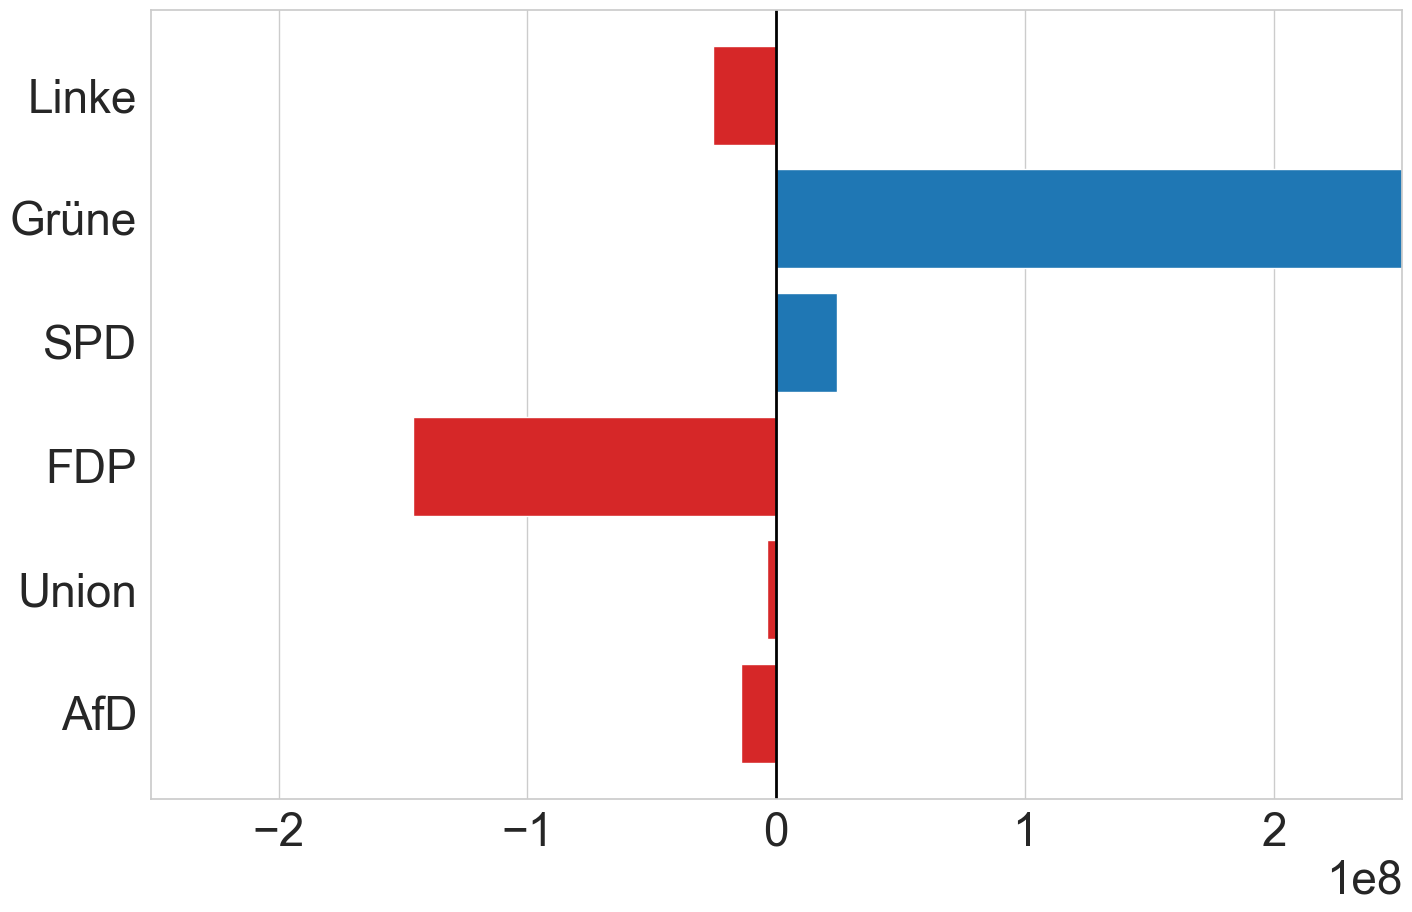

In [16]:
categories = party_order[::-1]

avg = np.mean(np.array([np.mean(df[df["party"] == k]["impressions_per_spending"]) for k in categories]))
values = np.array([avg * np.sum(df[df["party"] == k]["spend"]) - np.sum(df[df["party"] == k]["impressions"]) for k in categories])


# Plot price diff
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the horizontal bars
bars = ax.barh(categories, values, color=['tab:red' if val < 0 else 'tab:blue' for val in values])

print(values)
# Set the x-axis limits to center the bars at 0
ax.set_xlim(-max(abs(values)) - 1, max(abs(values)) + 1)


# Customize the plot
#ax.set_xlabel('Difference between avg. Impressions per spending and actual impressions')
ax.set_ylabel('')

# Add vertical grid lines
ax.grid(axis='y')

# Add a zero line
ax.axvline(0, color='black', linewidth=2)
plt.yticks(ticks=[0, 1, 2, 3, 4, 5][::-1], labels=party_labels.values())
#plt.xticks(ticks=[0, 1, 2, 3][::-1], labels=["- 3 x 10e7"])
plt.tight_layout()
#plt.savefig(path_figures + "efficiency_party_difference.pdf")

## Prevalence of targeting

In [17]:
from collections import Counter

# Statistics on ads with different targeting options
# targeting_columns = [c for c in df.columns if "include" in c and "raw" not in c and "location" not in c] + [c for c in df.columns if "exclude" in c and "raw" not in c]
include_other = [c for c in df.columns if c.startswith("include_") and "raw" not in c and "location" not in c]
exclude_other = [c for c in df.columns if c.startswith("exclude_") and "raw" not in c]

targeting_columns = [c for c in df.columns if "use" in c] + include_other + exclude_other
targeting_columns = [c for c in targeting_columns if "count" not in c]

L_all = df.__len__()
L_any = df[df[targeting_columns].any(axis=1) == 1].__len__()

print("% of ads with any targeting = " + "{:.2f}".format(L_any/L_all*100))

count = Counter()
for c in targeting_columns:
    x = df[df[c] == 1].__len__()
    count[c] = x/L_any*100

print()
print("% of ads with targeting cumulatively by decreasing order:")
ads = set()
cumulative_ads = []
for c in count.most_common():
    col = c[0]
    ads = ads.union(set(df[df[col] == 1]["id"]))
    print(col + " --> any notna= " + str(c[1]))
    print(ads.__len__()/L_any*100)
    cumulative_ads.append(ads.__len__()/L_any*100)

% of ads with any targeting = 72.32

% of ads with targeting cumulatively by decreasing order:
interests_exclude_use --> any notna= 69.76448446004375
69.76448446004375
employers_exclude_use --> any notna= 54.984146362141175
69.89504383064585
interests_include_use --> any notna= 27.75488749851637
92.21221832239686
behaviors_exclude_use --> any notna= 26.032182037065297
92.21221832239686
include_lookalike --> any notna= 6.5720535123861845
94.3656001492107
exclude_custom_audience --> any notna= 5.252895196432507
95.33716533563931
exclude_location --> any notna= 4.640792173220069
97.31420723332825
include_custom_audience --> any notna= 3.9812130152432306
97.75675263238212
exclude_lookalike --> any notna= 3.7014429353815896
97.77370839479798
industry_include_use --> any notna= 2.5687980060023397
97.7821862760059
behaviors_include_use --> any notna= 2.3822846194279124
97.81101107211285
employers_include_use --> any notna= 2.0686030147345575
97.81270664835444
education_level_include_use --> a

In [18]:
from collections import Counter

M_all = df["spend"].sum()
M_any = df[df[targeting_columns].any(axis=1) == 1]["spend"].sum()

print("% of money with any targeting = " + "{:.2f}".format(M_any/M_all*100))

count = Counter()
for c in targeting_columns:
    x = df[df[c] == 1]["spend"].sum()
    count[c] = x/M_any*100

print()
print("% of money with targeting cumulatively by decreasing order:")
ads = set()
cumulative_money = []
for c in count.most_common():
    col = c[0]
    print(col)
    print(df[df[col] == 1]["spend"].sum()/M_any * 100)
    ads = ads.union(set(df[df[col] == 1]["id"]))
    money = df[df["id"].isin(ads)]["spend"].sum()
    cumulative_money.append(money/M_any*100)
    print(money/M_any*100)

% of money with any targeting = 72.59

% of money with targeting cumulatively by decreasing order:
interests_exclude_use
65.80657139348396
65.80657139348396
interests_include_use
32.76168066543144
88.08570651025771
employers_exclude_use
26.11293736485819
88.20967660690474
exclude_location
19.153912740885424
90.38152348337881
behaviors_exclude_use
11.571649164596906
90.38152348337881
include_lookalike
10.877924241962864
95.72882827270915
exclude_custom_audience
7.649883202102817
97.81312337550412
include_custom_audience
6.958778356013713
98.15458693036693
behaviors_include_use
5.1736831777866525
98.17272286473649
exclude_lookalike
3.8514840503275987
98.21618591581444
employers_include_use
3.1508250002827323
98.21688102131291
job_title_include_use
2.5922243497008375
98.21688102131291
parents_include_use
2.448154575982457
98.26489596021581
industry_include_use
2.4456475098057524
98.26767638220974
education_level_include_use
1.623040819329875
98.29282656297309
include_connection
1.55342582

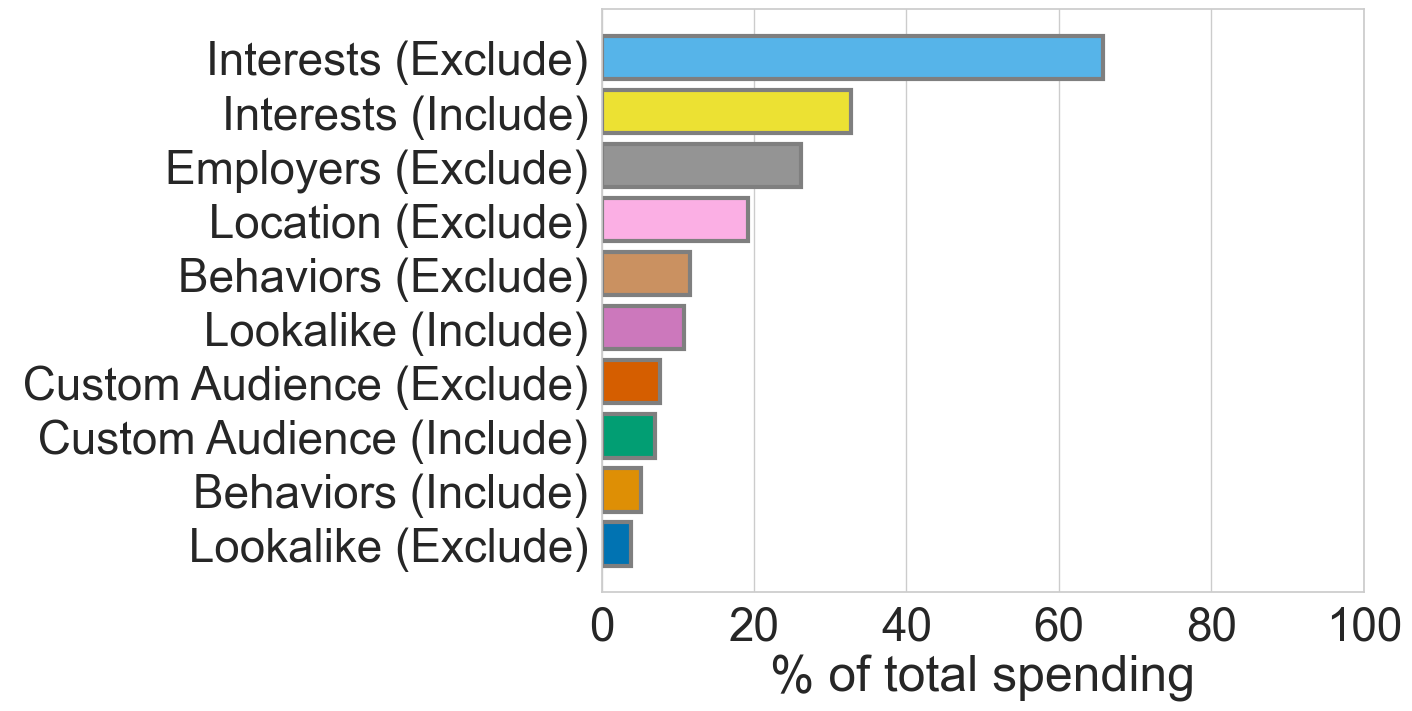

In [19]:

# Set up the plot
fig, ax = plt.subplots(1, figsize=(15, 8))

categories, values = zip(*count.most_common(10))

new_categories = []
for c in categories:
    new_c = c.split("_")
    include_flag = True if "include" in new_c else False
    new_c = [nc.replace("use", "").replace("include", "").replace("exclude", "") for nc in new_c]
    new_c = " ".join([nc.capitalize() for nc in new_c])
    new_c = new_c.rstrip() + " (Include)" if include_flag else new_c.rstrip() + " (Exclude)"
    new_categories.append(new_c)

# Plot the horizontal bars
bars = ax.barh(new_categories[::-1], values[::-1], color=sns.color_palette("colorblind"), linewidth=3, edgecolor="tab:grey",)

# Customize the plot
ax.set_xlabel('% of total spending')
ax.set_ylabel('')

# Add vertical grid lines
ax.yaxis.grid(False)
ax.xaxis.grid(True)
# ax.set_title("Top-10 targeting criteria")
ax.set_xlim(0, 100)

# ax2 = ax.twiny()
# ax2.plot(cumulative_ads[:10], range(10), ls="-", color="black", linewidth=4)
# ax2.set_xlabel("Cumulative % of ads", weight = 'bold')
# ax2.set_xlim(0, 100)
# ax2.set_xticks(ax2.get_xticks(), labels=ax2.get_xticklabels(), weight = 'bold')
    
plt.tight_layout()
plt.savefig(path_figures+"top-10_targeting_money.pdf")

Targeting columns:
interests_include_use industry_include_use parents_include_use job_title_include_use employers_include_use behaviors_include_use field_of_study_include_use life_event_include_use school_include_use education_level_include_use relationship_status_include_use income_include_use undergrad_years_include_use interests_exclude_use employers_exclude_use school_exclude_use education_level_exclude_use behaviors_exclude_use industry_exclude_use field_of_study_exclude_use job_title_exclude_use parents_exclude_use include_audience_data_missing include_connection include_custom_audience include_data_file_custom_audience include_friend_connection include_lookalike exclude_audience_data_missing exclude_connection exclude_custom_audience exclude_data_file_custom_audience exclude_location exclude_lookalike

afd
% of money with any targeting = 70.92
fdp
% of money with any targeting = 80.02
gruene
% of money with any targeting = 92.56
linke
% of money with any targeting = 69.10
spd
% 

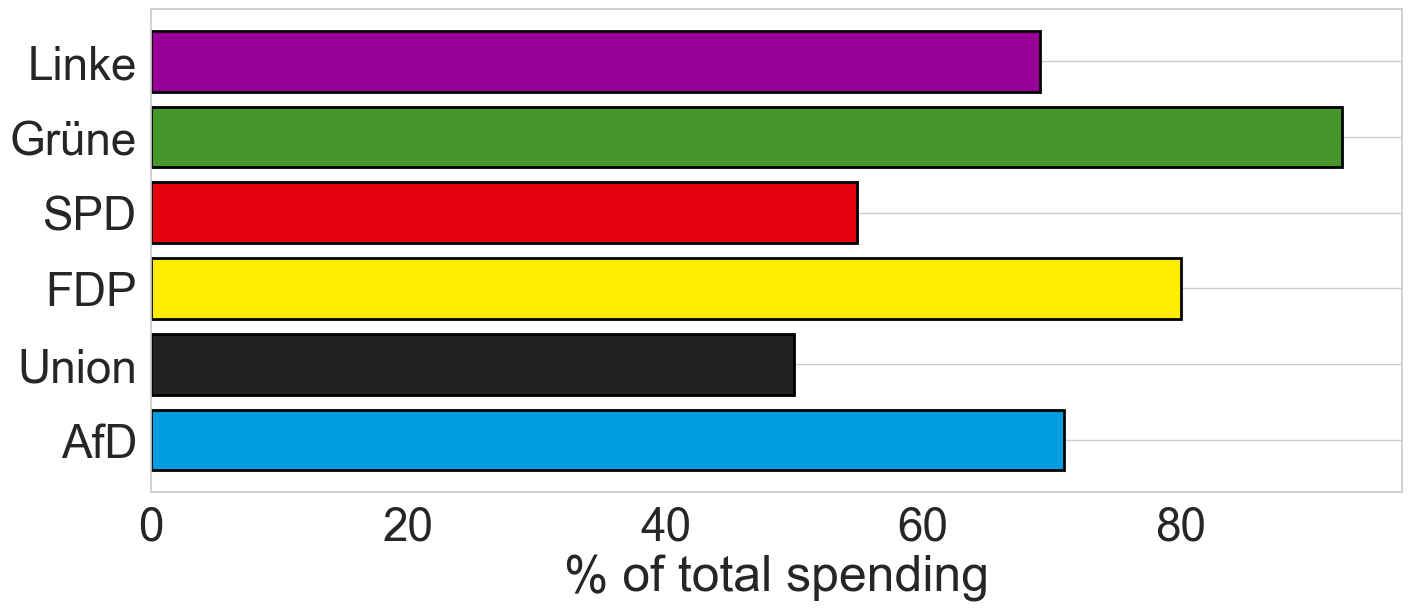

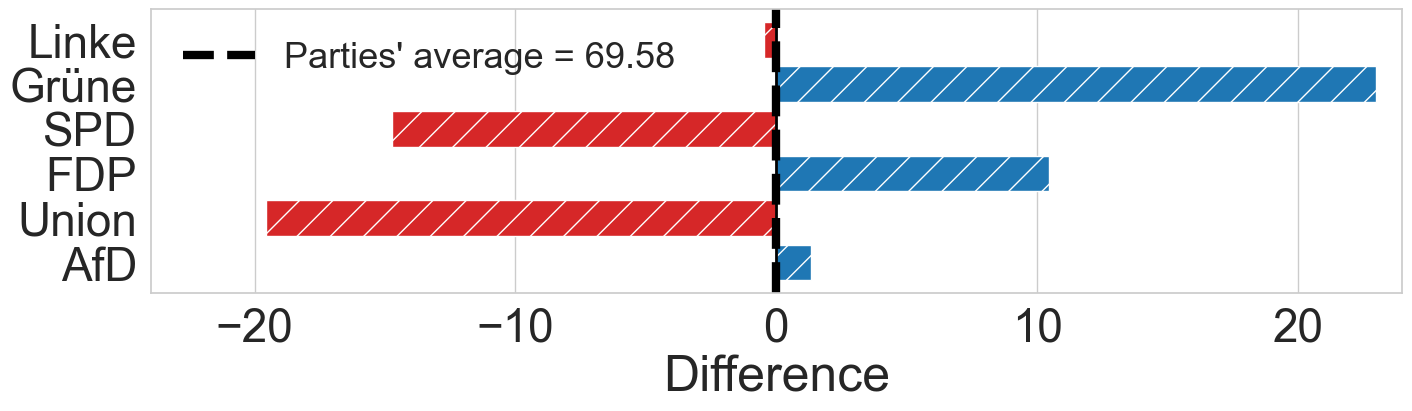

In [20]:
from collections import Counter, defaultdict

party_targeting_money_proportion = Counter()
party_targeting_money_criteria = dict()
party_targeting_money_cumulative = defaultdict(list)

print("Targeting columns:\n" + " ".join(targeting_columns))
print()

for ix, data in df.groupby("party"):
    print(ix)
    # Statistics on ads with different targeting options
    M_all = data["spend"].sum()
    M_any = data[data[targeting_columns].any(axis=1) == 1]["spend"].sum()
    
    party_targeting_money_proportion[ix] = M_any/M_all*100
    
    print("% of money with any targeting = " + "{:.2f}".format(M_any/M_all*100))

print()
    
for ix, data in df.groupby("party"):
    print(ix)
    # Statistics on ads with different targeting options
    M_all = data["spend"].sum()
    M_any = data[data[targeting_columns].any(axis=1) == 1]["spend"].sum()

    count = Counter()
    for c in targeting_columns:
        x = data[data[c] == 1]["spend"].sum()
        count[c] = x/M_any*100
        
    party_targeting_money_criteria[ix] = count
    
#    print("% of ads with targeting cumulatively by decreasing order:")
    ads = set()
    for c in count.most_common():
        col = c[0]
        ads = ads.union(set(data[data[col] == 1]["id"]))
        money = data[data["id"].isin(ads)]["spend"].sum()
#        print(col + " --> any notna= " + str(c[1]))
#        print(ads.__len__()/L_any*100)
        party_targeting_money_cumulative[ix].append(money/M_any*100)
#    print()

categories = party_order[::-1]
values = np.array([party_targeting_money_proportion[k] for k in categories])

# Set up the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

# plt.suptitle("Prevalence of targeting")

# Plot the horizontal bars
bars = ax.barh(categories, values, color=[party_pal[p] for p in categories], 
               capsize=6, edgecolor="black", linewidth=2)

avg = np.mean([party_targeting_money_proportion[k] for k in party_order])

# Customize the plot
ax.set_xlabel('% of total spending')
ax.set_ylabel('')
# ax.axvline(avg, linewidth=6, c ="black", ls="--", label="Mean = "+"{:.2f}".format(avg))
# ax.legend(frameon=False, loc="upper right")

# Add vertical grid lines
ax.grid(axis='x')
plt.yticks(ticks=[0, 1, 2, 3, 4, 5][::-1], labels=party_labels.values())

plt.tight_layout()
plt.savefig(path_figures + "prevalence_targeting_money_party.pdf")

print(values)

values -= avg

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot the horizontal bars
bars = ax.barh(categories, values, color=['tab:red' if val < 0 else 'tab:blue' for val in values], hatch="/")

# Set the x-axis limits to center the bars at 0
ax.set_xlim(-max(abs(values)) - 1, max(abs(values)) + 1)

# Customize the plot
ax.set_xlabel('Difference')
ax.set_ylabel('')

# Add vertical grid lines
ax.grid(axis='y')

# Add a zero line
ax.axvline(0, color='black', linewidth=2)
plt.yticks(ticks=[0, 1, 2, 3, 4, 5][::-1], labels=party_labels.values())

# Add a zero line
ax.axvline(0, linewidth=6, c ="black", ls="--", label="Parties' average = "+"{:.2f}".format(avg))

plt.legend(frameon=False, loc="upper left", fontsize=26)
plt.tight_layout()
# plt.savefig(path_figures + "prevalence_targeting_money_party.pdf")
# Add labels to the bars
#for bar in bars:
#    width = bar.get_width()
#    color = bar.get_facecolor()
#    ax.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.1f}', ha='left', va='center', color=color)


In [21]:
# Check whether ad uses targeting
print("All targeting columns: ")
print(targeting_columns)
targeting_condition = df[targeting_columns].any(axis=1) == 1
df["targeting_condition"] = targeting_condition 


All targeting columns: 
['interests_include_use', 'industry_include_use', 'parents_include_use', 'job_title_include_use', 'employers_include_use', 'behaviors_include_use', 'field_of_study_include_use', 'life_event_include_use', 'school_include_use', 'education_level_include_use', 'relationship_status_include_use', 'income_include_use', 'undergrad_years_include_use', 'interests_exclude_use', 'employers_exclude_use', 'school_exclude_use', 'education_level_exclude_use', 'behaviors_exclude_use', 'industry_exclude_use', 'field_of_study_exclude_use', 'job_title_exclude_use', 'parents_exclude_use', 'include_audience_data_missing', 'include_connection', 'include_custom_audience', 'include_data_file_custom_audience', 'include_friend_connection', 'include_lookalike', 'exclude_audience_data_missing', 'exclude_connection', 'exclude_custom_audience', 'exclude_data_file_custom_audience', 'exclude_location', 'exclude_lookalike']


/var/folders/b1/rdb8b9050b5_6qc4tjvfdpc80000gn/T/ipykernel_43571/1955995757.py:13: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i, bars, hatch, legend_handle in zip(range(12), ax.containers, ['', '/'], ax.legend_.legendHandles):


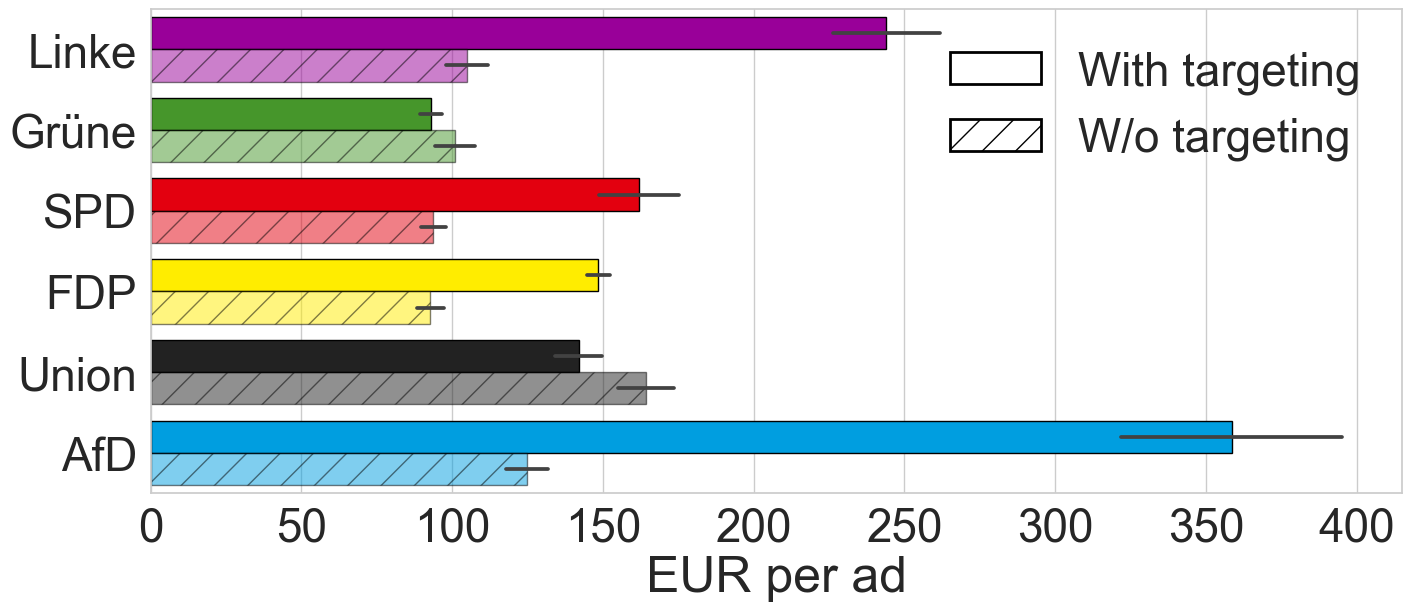

In [22]:
from matplotlib.patches import Patch

plt.figure(figsize=(15, 7))

df["Targeting"] = [str(t) for t in df["targeting_condition"]]
# Barplot

party_colors =  ["#990099", "#46962B", "#E3000F",  "#FFED00", "#222222","#009EE0"]

ax = sns.barplot(data=df, x="spend", y="party", hue="Targeting", errorbar="se",
            order=party_order)

for i, bars, hatch, legend_handle in zip(range(12), ax.containers, ['', '/'], ax.legend_.legendHandles):
     for bar, color in zip(bars, party_colors):
          bar.set_facecolor(color)
          bar.set_hatch(hatch)
          bar.set_edgecolor("black")
          if i % 2 == 1:
               bar.set_alpha(0.5)

legend_elements = [Patch(facecolor='white', edgecolor='black', linewidth=2,
                         label='With targeting'),
                   Patch(facecolor='white', edgecolor='black', linewidth=2, hatch="/",
                         label='W/o targeting')]
plt.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.yticks(ticks=[0, 1, 2, 3, 4, 5], labels=party_labels.values())
plt.xlabel("EUR per ad")
plt.ylabel("")
plt.tight_layout()
plt.savefig(path_figures + "money_spent_targeting_not.pdf")
plt.show()




In [23]:
# print("Alpha corrected = "+str(0.05/6))
alpha = 0.05/6
pvals = []
for ix, data in df.groupby("party"):
    print(ix)
    data = data[data["spend"].notna()]
    x = data[data["Targeting"] == "True"]["spend"].values
    y = data[data["Targeting"] == "False"]["spend"].values
    pval = ss.f_oneway(x,y).pvalue
    # print(pval)
    # print(pval <= alpha)
    pvals.append(pval)

multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', maxiter=1, is_sorted=False, returnsorted=False)


afd
fdp
gruene
linke
spd
union


(array([ True,  True, False,  True,  True, False]),
 array([3.51873388e-11, 8.20980161e-16, 5.44064788e-01, 5.69668765e-13,
        2.90802302e-08, 7.71738472e-02]),
 0.008512444610847103,
 0.008333333333333333)

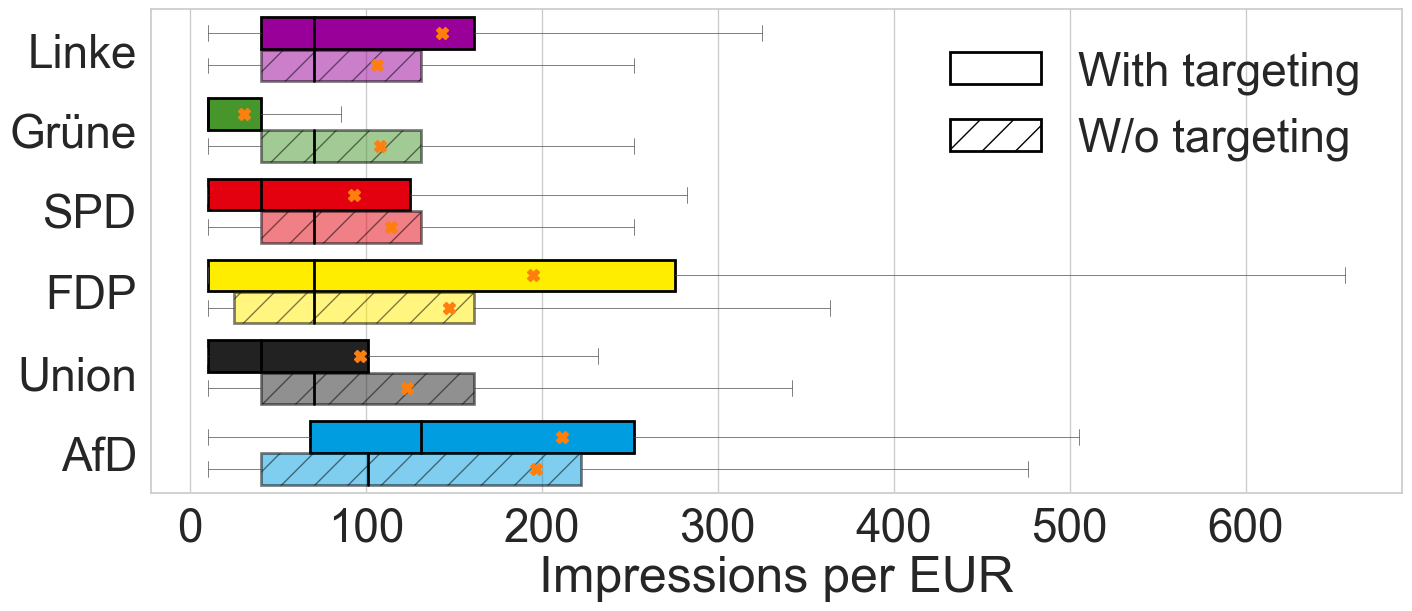

In [24]:
from matplotlib.patches import Patch

plt.figure(figsize=(15, 7))

# Boxplot
box = sns.boxplot(data=df, x="impressions_per_spending", y="party", hue="targeting_condition",
            showfliers=False, showmeans=True, linewidth=0.5,
            order=party_order, hue_order=[True, False],
            meanprops={"marker":"X",
                       "markerfacecolor":"tab:orange", 
                       "markeredgecolor":"tab:orange",
                       "markersize":"8"},           
            medianprops={'linewidth':2, 'color':'black'},
            boxprops = {"linewidth":2, 'edgecolor':'black'})

party_colors =  ["#990099", "#990099", "#46962B", "#46962B", "#E3000F", "#E3000F", "#FFED00", "#FFED00", "#222222", "#222222", "#009EE0", "#009EE0"]

boxes = list(box.patches)[3:]

# For first box
box.patches[1].set_facecolor(party_colors[0])

for i in range(0, len(boxes)):
    boxes[i].set_facecolor(party_colors[i+1])
    if (i==0) or (i % 2 == 0):
        boxes[i].set(facecolor = party_colors[i+1], alpha=.5)
        boxes[i].set(hatch = '/')
    boxes[i].set(edgecolor='black')

median_lines = [line for line in box.get_lines() if line.get_label() == '_median_']
for i, line in enumerate(median_lines):
    line.set_color(party_colors[i % len(party_colors)])
    
# Customize legend
# plt.legend([box.patches[1], box.patches[3]], ['Targeting', 'No targeting'], loc='upper right', frameon=False)
#leg = box.get_legend()
#leg.legendHandles[0].set_color('white')
#leg.legendHandles[1].set_color('white')

legend_elements = [Patch(facecolor='white', edgecolor='black', linewidth=2,
                         label='With targeting'),
                   Patch(facecolor='white', edgecolor='black', linewidth=2, hatch="/",
                         label='W/o targeting')]
plt.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.yticks(ticks=[0, 1, 2, 3, 4, 5], labels=party_labels.values())
plt.xlabel("Impressions per EUR")
plt.ylabel("")
plt.tight_layout()
plt.savefig(path_figures + "efficiency_targeting_not.pdf")
plt.show()


In [25]:
# print("Alpha corrected = "+str(0.05/6))
alpha = 0.05/6
pvals = []
for ix, data in df.groupby("party"):
    print(ix)
    data = data[data["impressions_per_spending"].notna()]
    x = data[data["Targeting"] == "True"]["impressions_per_spending"].values
    y = data[data["Targeting"] == "False"]["impressions_per_spending"].values
    print(np.median(x))
    print(np.median(y))
    pval = ss.kruskal(x,y).pvalue
    print(pval)
    # print(pval <= alpha)
    pvals.append(pval)

multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', maxiter=1, is_sorted=False, returnsorted=False)


afd
131.3030303030303
101.0
0.000209920857687007
fdp
70.6969696969697
70.6969696969697
1.2776116429135726e-05
gruene
10.090909090909092
70.6969696969697
0.0
linke
70.6969696969697
70.6969696969697
0.003946442358585864
spd
40.39393939393939
70.6969696969697
8.520859421172296e-35
union
40.39393939393939
70.6969696969697
4.077008520469656e-116


(array([ True,  True,  True,  True,  True,  True]),
 array([2.51905029e-004, 1.91641746e-005, 0.00000000e+000, 3.94644236e-003,
        1.70417188e-034, 1.22310256e-115]),
 0.008512444610847103,
 0.008333333333333333)

## Number of targeting options per ad

In [26]:
target_options_counter = defaultdict(Counter)
target_options_money_counter = defaultdict(Counter)

include_other = [c for c in df.columns if c.startswith("include_") and "raw" not in c and "location" not in c]
exclude_other = [c for c in df.columns if c.startswith("exclude_") and "raw" not in c]

targeting_columns = [c for c in df.columns if "use" in c] + include_other + exclude_other
targeting_columns = [c for c in targeting_columns if "count" not in c]

for ix, row in df.iterrows():
    money = row["spend"]
    party = row["party"]
    for c in targeting_columns:
        if row[c] != 0:
            if c not in (include_other + exclude_other):
                for t in eval(row[c.replace("_use", "")]):
                    if "include" in c:
                        t += "_include"
                    else:
                        t += "_exclude"
                    target_options_counter[party][t] += 1
                    target_options_money_counter[party][t] += money
            else:
                target_options_counter[party][c] += 1
                target_options_money_counter[party][c] += money


In [27]:
for c in targeting_columns:
    if row[c] != 0:
        print(c)
        if c+"_count" in df.columns:
            print(c)

exclude_custom_audience


In [28]:
criteria_column_count = [c.replace("use", "count") for c in df.columns if "use" in c]
df["count_criteria"] = df[criteria_column_count].sum(axis = 1)

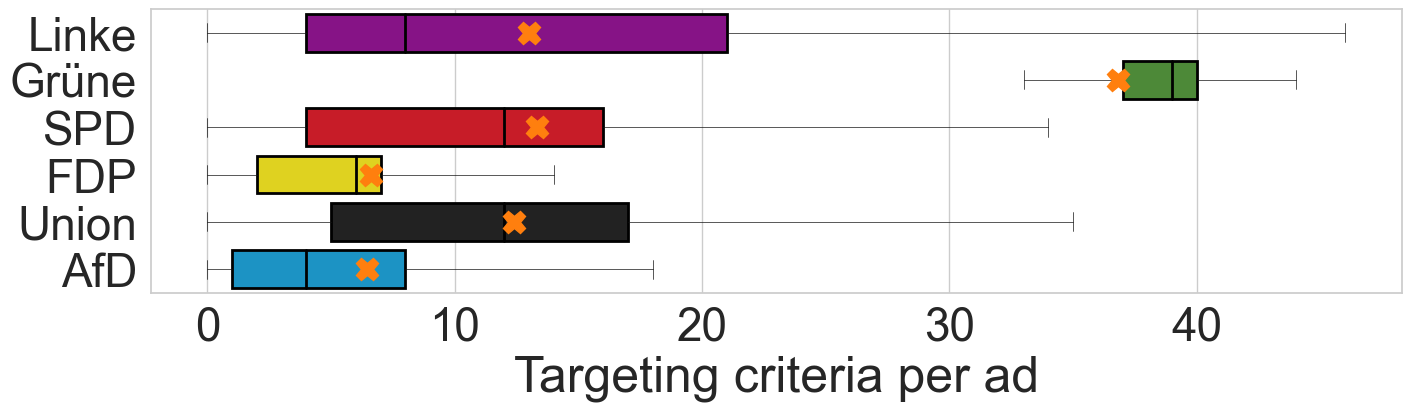

In [29]:
plt.figure(figsize=(15, 5))
# Boxplot
sns.boxplot(data=df[df["total_count"] > 0], x="count_criteria", y="party", showfliers=False, showmeans=True, 
            linewidth=0.5, 
            palette=party_pal, order=party_order,
            meanprops={"marker":"X",
                       "markerfacecolor":"tab:orange", 
                       "markeredgecolor":"tab:orange",
                       "markersize":"16"},           
            medianprops={'linewidth':2, 'color':'black'},
            boxprops = {"linewidth":2, 'edgecolor':'black'})

plt.yticks(ticks=[0, 1, 2, 3, 4, 5], labels=party_labels.values())
plt.xlabel("Targeting criteria per ad")
plt.ylabel("")
plt.tight_layout()
plt.savefig(path_figures + "targeting_options_length.pdf")
plt.show()



## Targeting other parties

In [30]:
# Prepare data for sankey plot

# Check if ad targets other party
data = df[["id", "party", "interests_include", "impressions", "spend"]]
data = data.dropna()

# Explode dataframe by criteria
data["interests_include"] = [eval(d) for d in data["interests_include"]]
data = data.explode("interests_include")

# Compute the number of criteria per ad
num_criteria = data.groupby("id").size().reset_index(name="num_criteria")

# Add number of criteria to dataframe
data = data.merge(num_criteria, how="left", left_on="id", right_on="id")

# Compute spending and impressions per criteria
data["spend_per_criteria"] = data["spend"] / data["num_criteria"]
data["impressions_per_criteria"] = data["impressions"] / data["num_criteria"]
data.drop(columns=["num_criteria", "impressions", "spend"], inplace=True)

# Filter if not a key in party_mapping
data = data.loc[data["interests_include"].isin(party_mapping.keys())]

# Replace keys with values
data["interests_include"] = data["interests_include"].replace(party_mapping)

# Re-group to ad level by id and sum up spending and impressions
data = data.groupby(["id", "party", "interests_include"]).agg({"spend_per_criteria": "sum", "impressions_per_criteria": "sum"}).reset_index()

# Map party labels to party names
data['party'] = data['party'].map(party_labels)
data['interests_include'] = data['interests_include'].map(party_labels)

print(data.__len__())
print(data["spend_per_criteria"].sum())

sankey_pal = {"Linke": "#990099", "Grüne": "#46962B", "SPD": "#E3000F" , "FDP": "#FFED00", "Union": "#222222", "AfD": "#009EE0"}



9611
506444.5692806827


1601.8333333333333
84407.42821344711


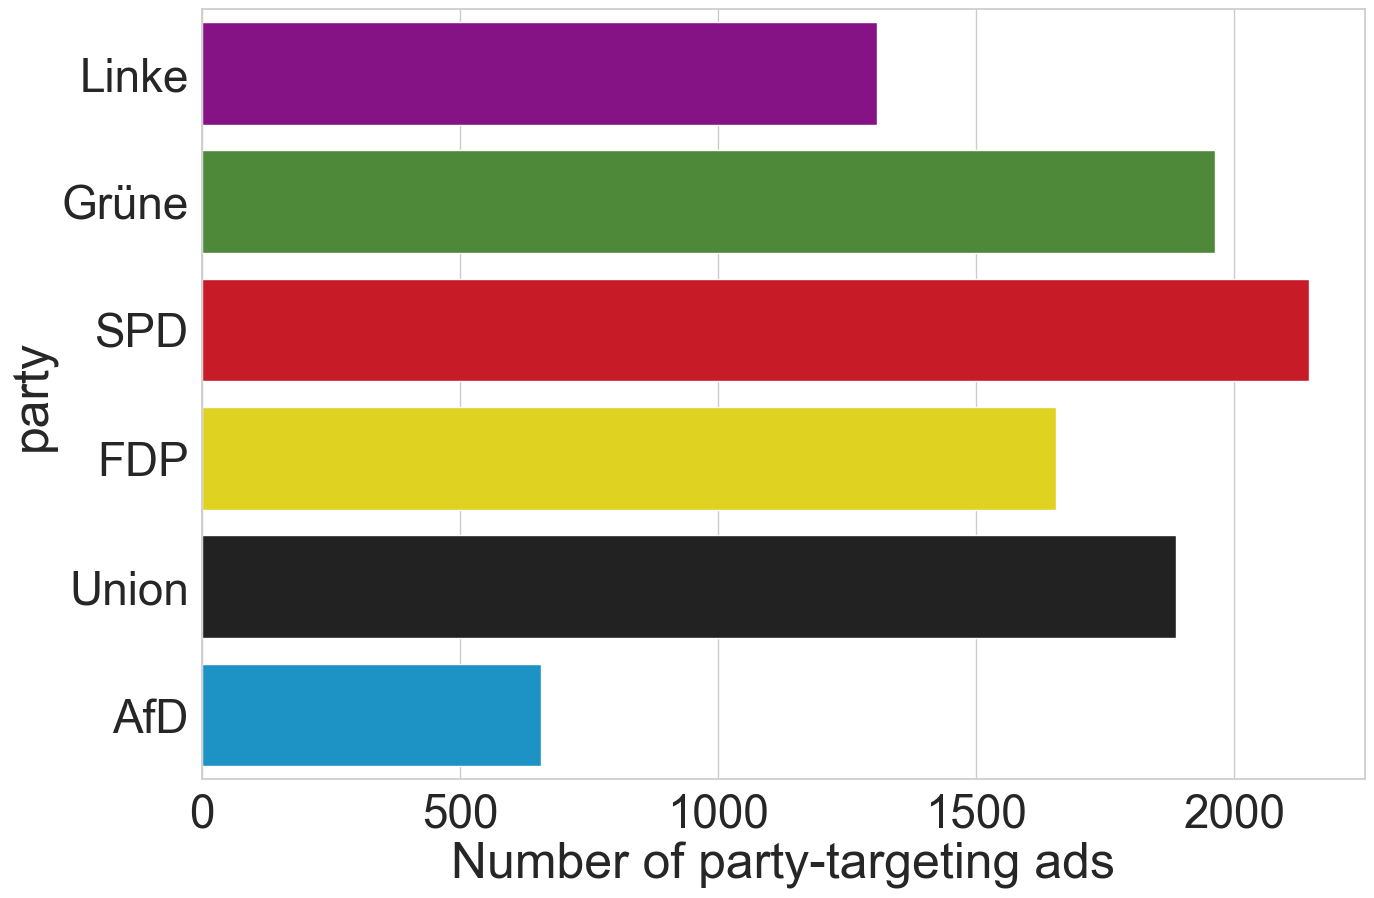

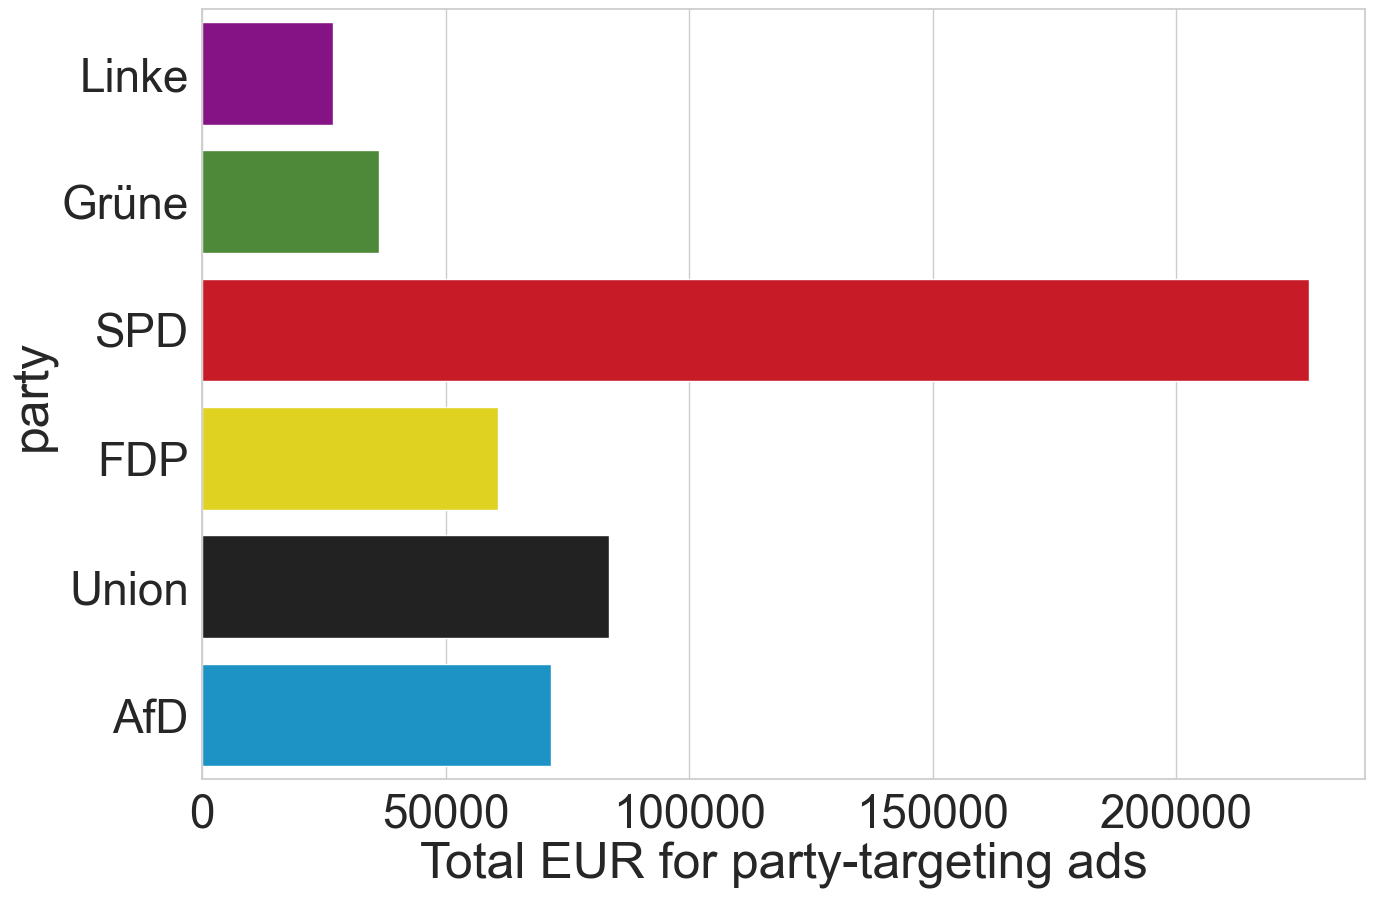

In [31]:
plt.figure(figsize=(15, 10))
sns.barplot(x="id", y="party", order=["AfD", "Union", "FDP", "SPD", "Grüne", "Linke"][::-1], palette=[party_pal[p] for p in party_order], data=data.groupby("party").count().reset_index())
plt.xlabel("Number of party-targeting ads")

print(data.groupby("party").count().mean()["id"])

plt.figure(figsize=(15, 10))
sns.barplot(x="spend_per_criteria", y="party", order=["AfD", "Union", "FDP", "SPD", "Grüne", "Linke"][::-1], palette=[party_pal[p] for p in party_order], data=data.groupby("party").sum().reset_index())
plt.xlabel("Total EUR for party-targeting ads")
print(data.groupby("party").sum()["spend_per_criteria"].mean())

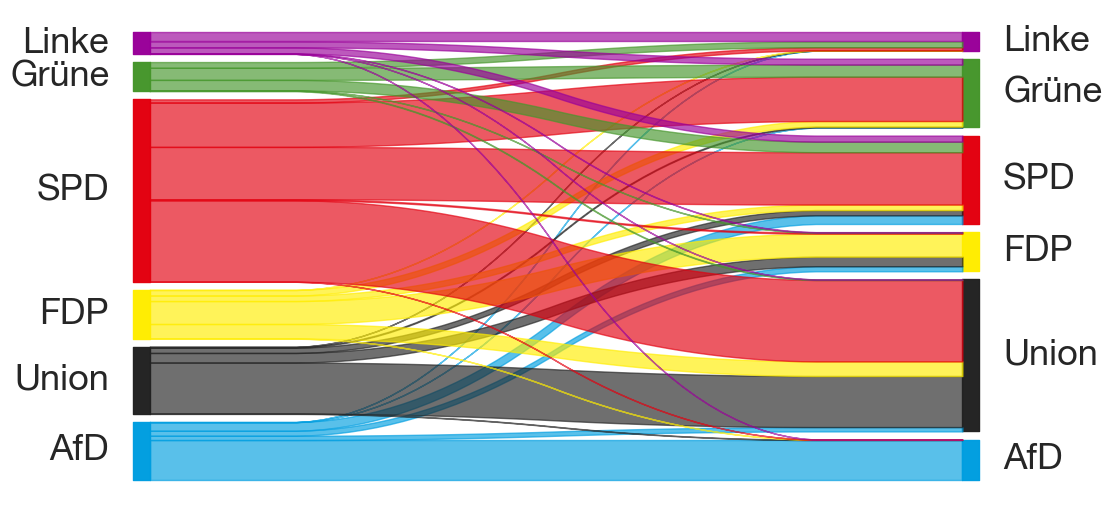

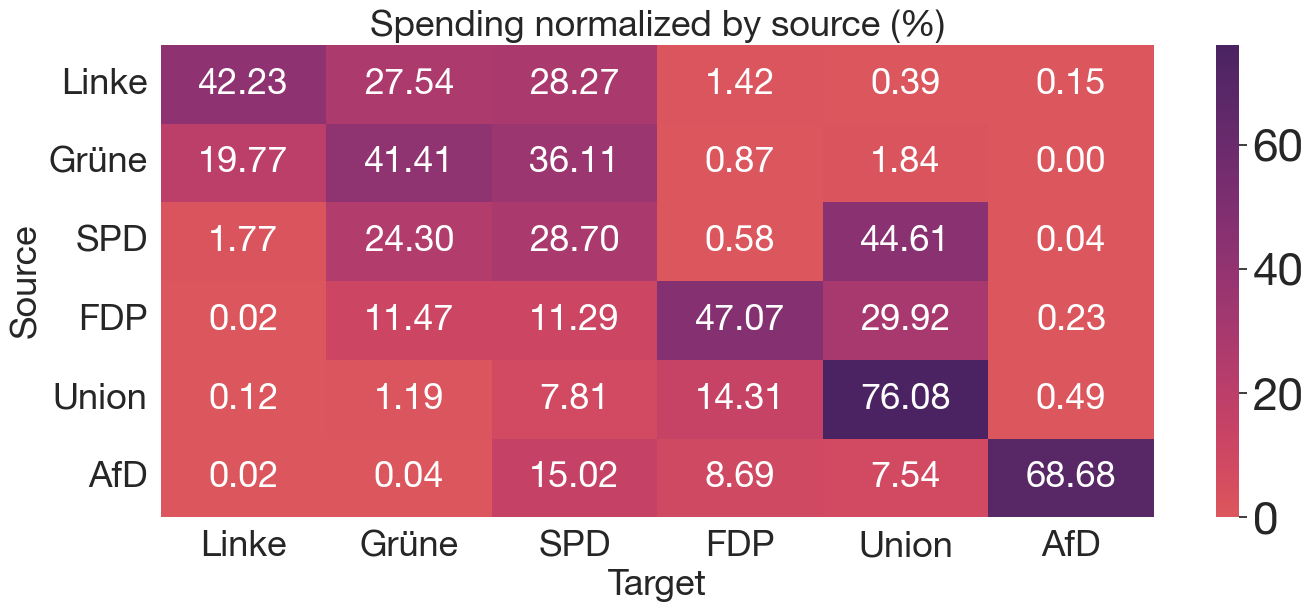

In [32]:
# Create sankey plot

fig, ax = plt.subplots(1, figsize=(12, 6))


# Create sankey plot
s = sankey(right=data["interests_include"], left=data["party"],
       leftWeight=data["spend_per_criteria"], rightWeight=data["spend_per_criteria"],
       colorDict=sankey_pal, ax=ax, fontsize=26,
       leftLabels=["AfD", "Union", "FDP", "SPD", "Grüne", "Linke"],
       rightLabels=["AfD", "Union", "FDP", "SPD", "Grüne", "Linke"])
#plt.title("Money")
plt.tight_layout()
plt.savefig(path_figures + "sankey_spend.pdf")

X = np.zeros((6,6))
i = 0
for p in party_labels:
       p = party_labels[p]
       source_total = data[data["party"] == p]["spend_per_criteria"].sum()
       j = 0
       for q in party_labels:
              q = party_labels[q]
              try:
                     val = data[(data["party"] == p) & (data["interests_include"] == q)]["spend_per_criteria"].sum()/source_total*100
              except:
                     val = 0
              X[i, j] = val
              j += 1
       i += 1

fig, ax = plt.subplots(1, figsize=(15, 7))


mean = np.mean(X)
g = sns.heatmap(ax=ax, data=X, annot=True, fmt=".2f", annot_kws={"fontsize":26}, center=mean, cmap="flare", xticklabels=[party_labels[p] for p in party_labels], yticklabels = [party_labels[p] for p in party_labels])

ax.set_xticklabels(g.get_xmajorticklabels(), fontsize = 26)
ax.set_yticklabels(g.get_ymajorticklabels(), fontsize = 26)


plt.title("Spending normalized by source (%)", fontsize=26)
plt.xlabel("Target", fontsize=26)
plt.ylabel("Source", fontsize=26)
plt.tight_layout()

plt.savefig(path_figures + "sankey_spend_heatmap.pdf")

Text(0.5, 1.0, 'Number of ads normalized by source')

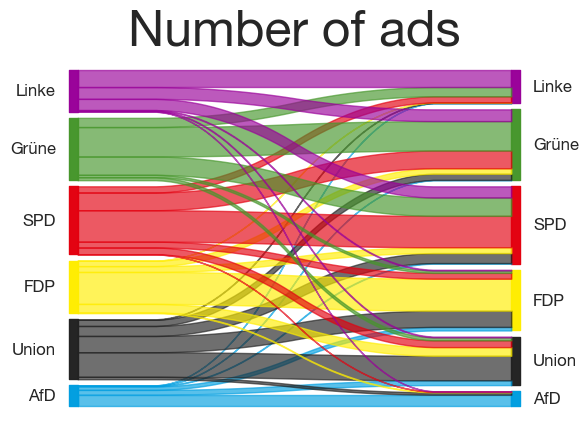

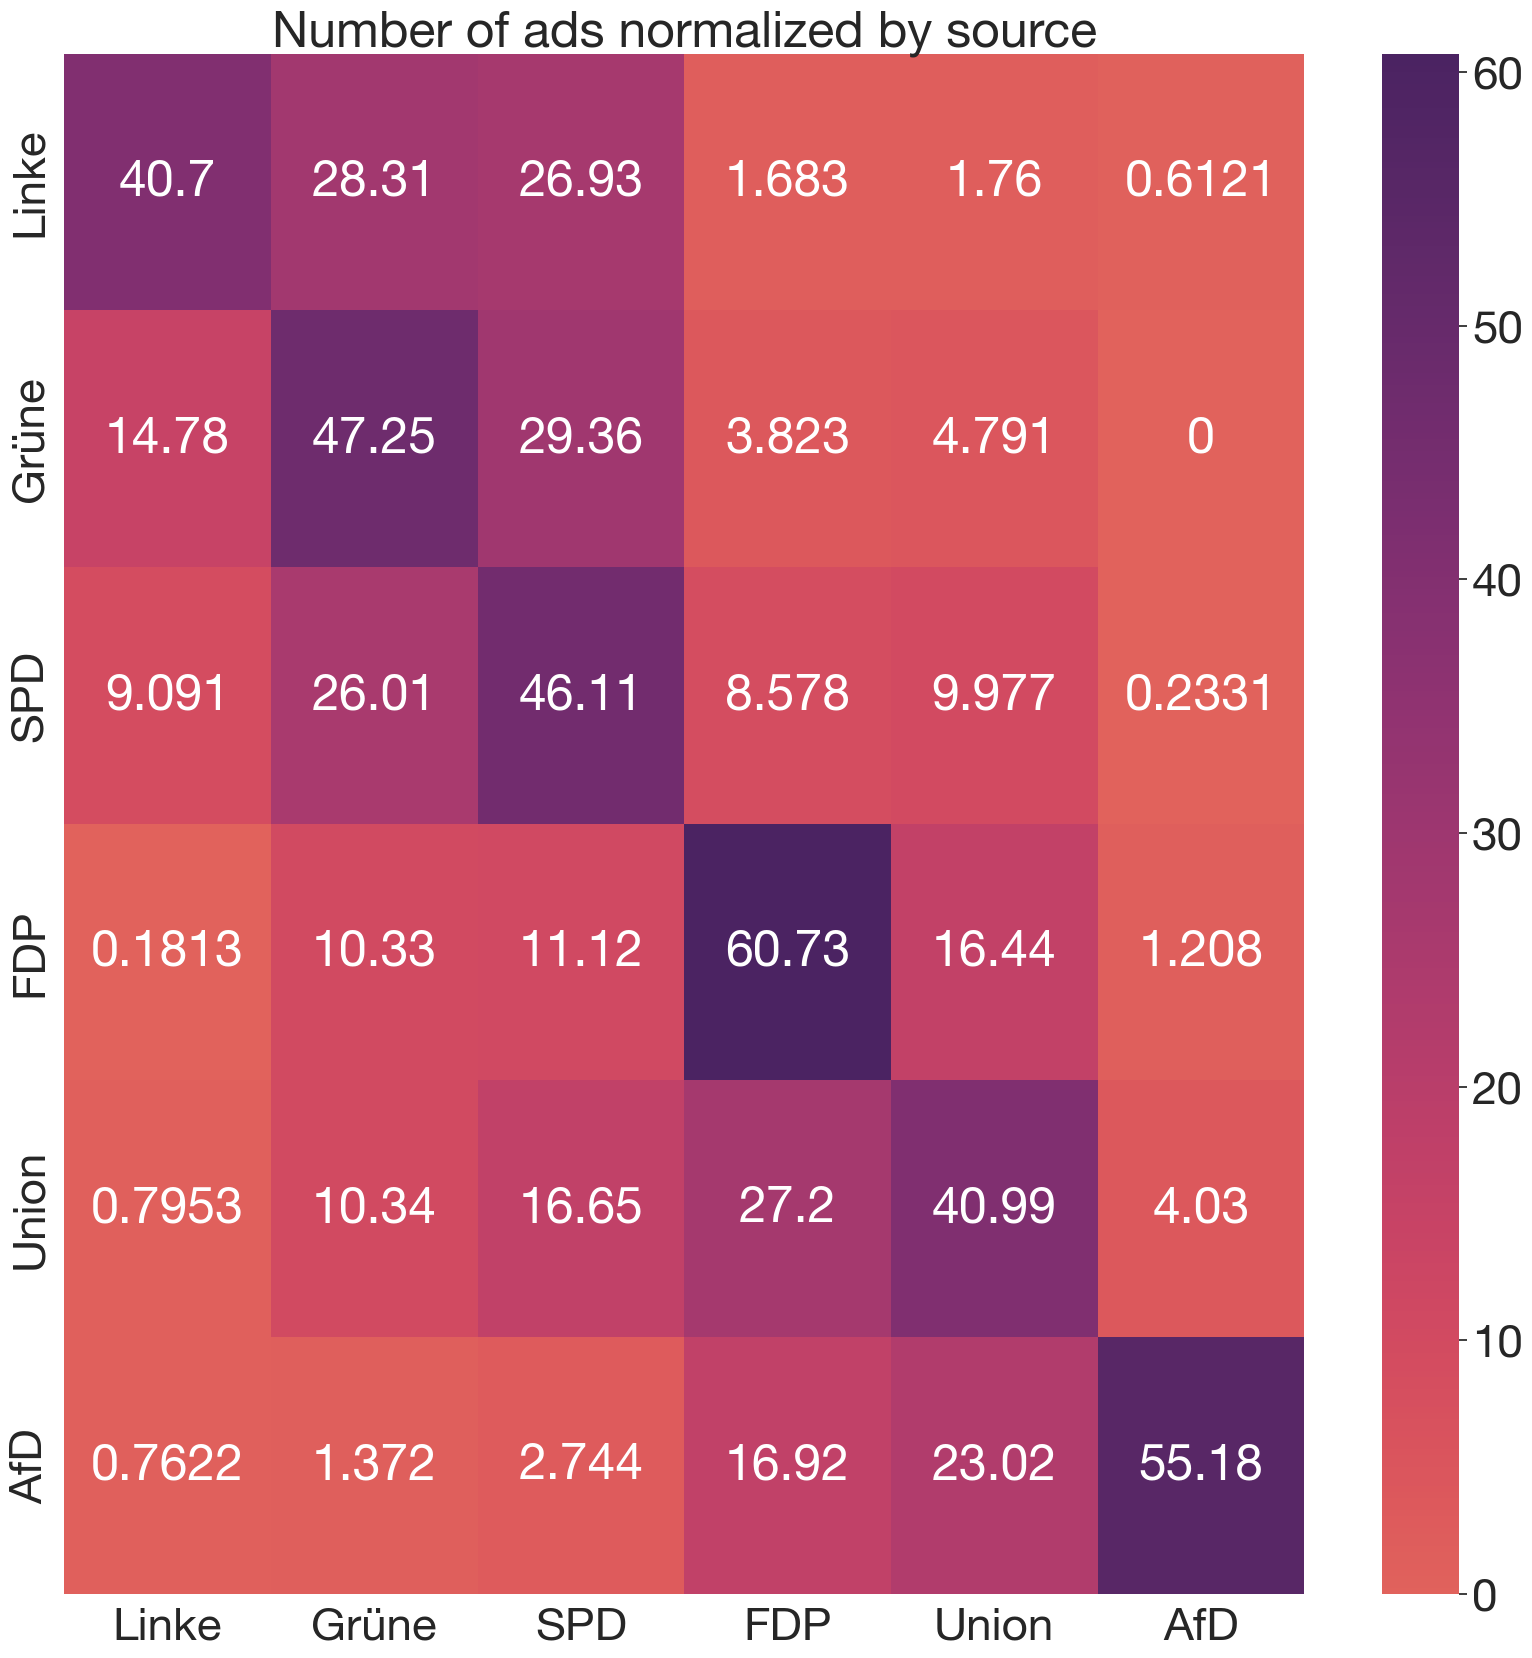

In [33]:
# Create sankey plot

ddata = data.groupby(["party", "interests_include"]).count().reset_index()

# Define color palette
sankey_pal = {"Linke": "#990099", "Grüne": "#46962B", "SPD": "#E3000F" , "FDP": "#FFED00", "Union": "#222222", "AfD": "#009EE0"}

# Create sankey plot
s = sankey(right=ddata["interests_include"], left=ddata["party"],
       leftWeight=ddata["spend_per_criteria"], rightWeight=ddata["spend_per_criteria"],
       colorDict=sankey_pal, aspect=20, fontsize=12,
       leftLabels=["AfD", "Union", "FDP", "SPD", "Grüne", "Linke"],
       rightLabels=["AfD", "Union", "FDP", "SPD", "Grüne", "Linke"])
plt.title("Number of ads")
# plt.savefig(path_figures + "DE_sankey_spend.pdf")

X = np.zeros((6,6))
i = 0
for p in party_labels:
       p = party_labels[p]
       source_total = ddata[ddata["party"] == p]["spend_per_criteria"].sum()
       j = 0
       for q in party_labels:
              q = party_labels[q]
              try:
                     val = ddata[(ddata["party"] == p) & (ddata["interests_include"] == q)]["spend_per_criteria"].sum()/source_total*100
              except:
                     val = 0
              X[i, j] = val
              j += 1
       i += 1

plt.figure(figsize=(20, 20))
mean = np.mean(X)
sns.heatmap(data=X, annot=True, fmt=".4g", center=mean, cmap="flare", xticklabels=[party_labels[p] for p in party_labels], yticklabels = [party_labels[p] for p in party_labels])
plt.title("Number of ads normalized by source")

Text(0.5, 1.0, 'Impressions normalized by source')

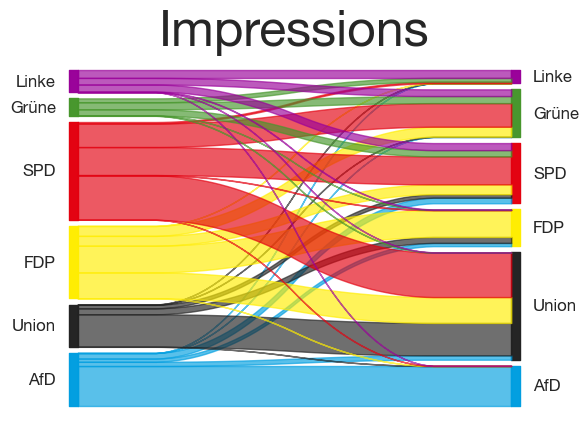

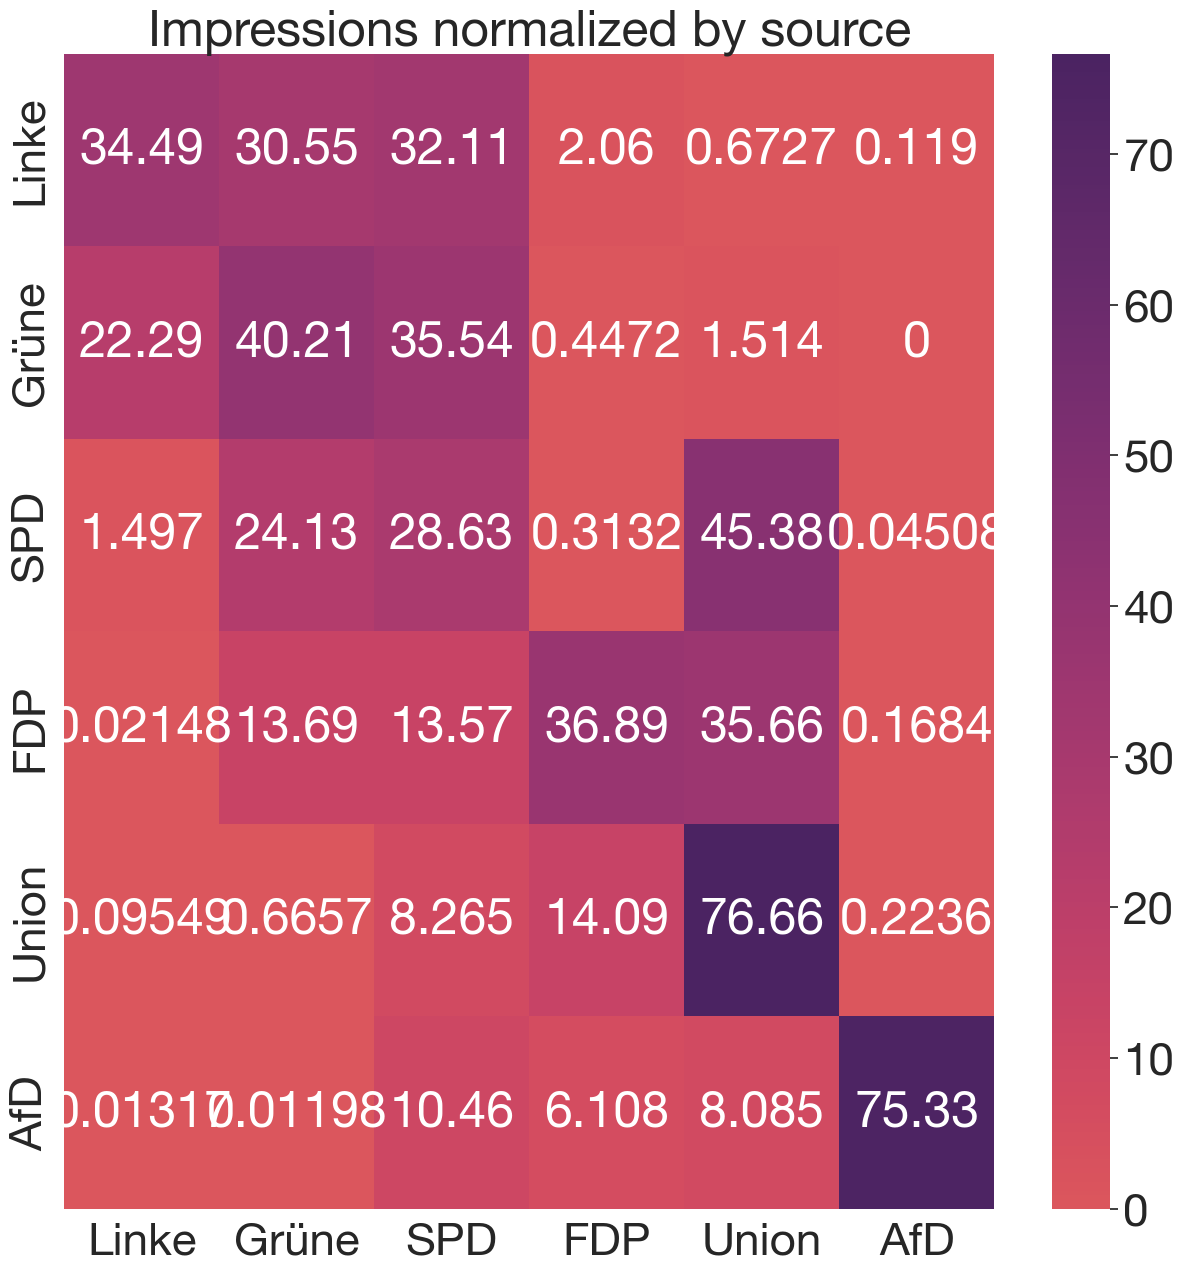

In [34]:
sankey(right=data["interests_include"], left=data["party"],
       leftWeight=data["impressions_per_criteria"], rightWeight=data["impressions_per_criteria"],
       colorDict=sankey_pal, aspect=20, fontsize=12,
       leftLabels=["AfD", "Union", "FDP", "SPD", "Grüne", "Linke"],
       rightLabels=["AfD", "Union", "FDP", "SPD", "Grüne", "Linke"])
plt.title("Impressions")

X = np.zeros((6,6))
i = 0
for p in party_labels:
       p = party_labels[p]
       source_total = data[data["party"] == p]["impressions_per_criteria"].sum()
       j = 0
       for q in party_labels:
              q = party_labels[q]
              # target_total = data[data["party"] == q]["impressions_per_criteria"].sum()
              try:
                     val = data[(data["party"] == p) & (data["interests_include"] == q)]["impressions_per_criteria"].sum()/source_total*100
              except:
                     val = 0
              X[i, j] = val
              j += 1
       i += 1

plt.figure(figsize=(15, 15))
mean = np.mean(X)
sns.heatmap(data=X, annot=True, fmt=".4g", center=mean, cmap="flare", xticklabels=[party_labels[p] for p in party_labels], yticklabels = [party_labels[p] for p in party_labels])
plt.title("Impressions normalized by source")

## Algorithmic discrepancy

### Age discrepancy

In [35]:
def extract_avg_age_distributions(data):
    actual_age_distribution_sum = Counter()
    for age in ['13-17',
           '18-24', '25-34', '35-44', '45-54', '55-64', '65+']:
        actual_age_distribution_sum[age] = 0
    targeting_age_distribution_sum = actual_age_distribution_sum.copy()
    
    count = 0
    for val in data["actual_age_distribution"].values:
        if "nan" in str(val):
            continue
        count += 1
        actual_age_distribution_sum.update(val)
    for age in actual_age_distribution_sum:
        actual_age_distribution_sum[age]/=count

    count = 0
    for val in data["targeting_age_distribution"].values:
        if "nan" in str(val):
            continue
        count += 1
        targeting_age_distribution_sum.update(val)
    for age in targeting_age_distribution_sum:
        targeting_age_distribution_sum[age]/=count
        
    return actual_age_distribution_sum,  targeting_age_distribution_sum

def extract_weighted_avg_age_distributions(data):
    actual_age_distribution_sum = Counter()
    for age in ['13-17',
           '18-24', '25-34', '35-44', '45-54', '55-64', '65+']:
        actual_age_distribution_sum[age] = 0
    targeting_age_distribution_sum = actual_age_distribution_sum.copy()
    
    weights = data["spend"]
    
    count = 0
    
    for w, val in zip(weights, data["actual_age_distribution"].values):
        if "nan" in str(val):
            continue
        count += w
        val = val.copy()
        for k in val:
            val[k]*=w
        actual_age_distribution_sum.update(val)
    for age in actual_age_distribution_sum:
        actual_age_distribution_sum[age]/=count

    weights = data["spend"]
        
    count = 0
    for w, val in zip(weights, data["targeting_age_distribution"].values):
        if "nan" in str(val):
            continue
        count += w
        val = val.copy()
        for k in val:
            val[k]*=w
        targeting_age_distribution_sum.update(val)
    for age in targeting_age_distribution_sum:
        targeting_age_distribution_sum[age]/=count
        
    return actual_age_distribution_sum, targeting_age_distribution_sum

In [36]:
for col in ['targeting_gender_distribution', 'actual_age_distribution',
            'targeting_age_distribution', 'actual_gender_distribution']:
    df[col] = [eval(v) for v in df[col]]

linke
4.693457886168511
gruene
6.353493067468493
spd
4.6181485651294185
fdp
5.188247646081376
union
5.691369354207836
afd
4.89363258882703


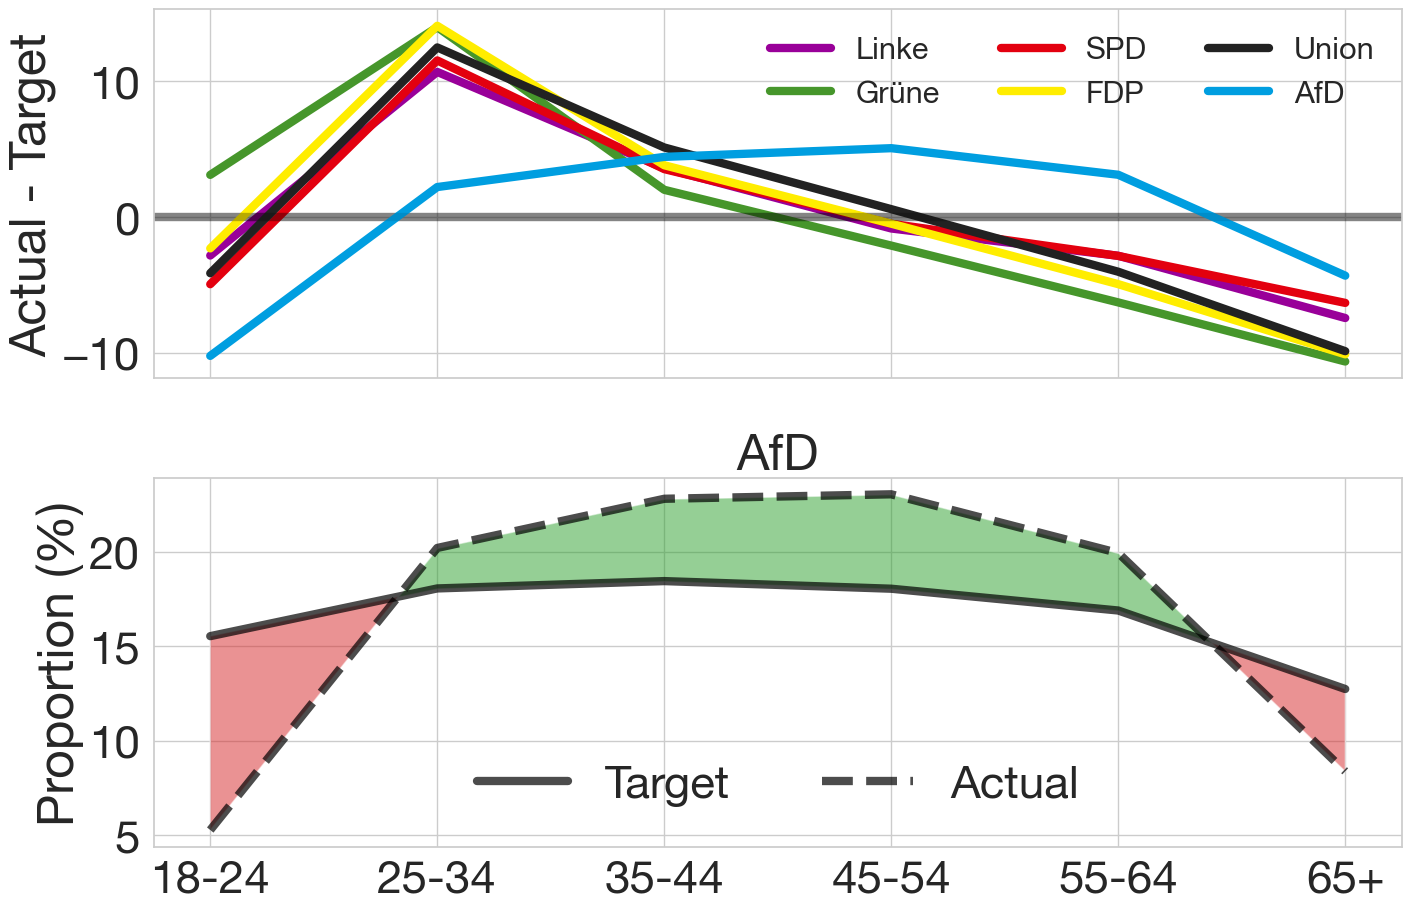

In [86]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

ix = "afd"

data = df[df.party == ix]

ax = axs[1]

actual_age_distribution_sum, targeting_age_distribution_sum = extract_weighted_avg_age_distributions(data)
target = targeting_age_distribution_sum
actual = actual_age_distribution_sum

y1 = np.array(list(actual.values()))[1:]*100
y2 = np.array(list(target.values()))[1:]*100

ax.plot(y2, color="black", alpha=.7, linewidth=6, ls="-", label="Target")
ax.plot(y1, color="black", alpha=.7, linewidth=6, ls="--", label="Actual")

x = range(6)

ax.fill_between(range(6), y1, y2,  where=y2 >= y1,
            facecolor="tab:red", interpolate=True, alpha=0.5)
ax.fill_between(range(6), y1, y2,  where=y2 < y1,
            facecolor="tab:green", interpolate=True, alpha=0.5)

ax.set_xticks([0, 1, 2, 3, 4, 5],labels=['18-24', '25-34', '35-44', '45-54', '55-64', '65+'])
ax.legend(frameon=False, ncols=2)
ax.set_title(party_labels[ix])
ax.set_ylabel("Proportion (%)")

# fig.savefig(path_figures+ "afd_age_difference.pdf")

ax = axs[0]

for ix in party_order:
   data = df[df.party == ix]
   data = data[data["18-24"] != "False"]
   data = data[data["age_distribution_distance"].notna()]

   actual_age_distribution_sum, targeting_age_distribution_sum = extract_weighted_avg_age_distributions(data)
   target = targeting_age_distribution_sum
   actual = actual_age_distribution_sum

   y1 = np.array(list(actual.values()))[1:]
   y2 = np.array(list(target.values()))[1:]

   diff_line = y1 - y2
   ws = ss.wasserstein_distance(y1*100, y2*100)

   print(ix)
   print(ws)

   ax.plot(diff_line*100, color=party_pal[ix], linewidth=6, label=party_labels[ix])
   ax.axhline(0, color="black", alpha=.1, ls="-", linewidth=6)

ax.set_xticks([0, 1, 2, 3, 4, 5],labels=['18-24', '25-34', '35-44', '45-54', '55-64', '65+'])
ax.legend(loc="upper right", fontsize=22, frameon=False, ncols=3)
ax.set_ylabel("Actual - Target")

plt.tight_layout()

fig.savefig(path_figures + "afd_parties_age_difference.pdf")


### Gender discrepancy 

In [38]:
def extract_avg_gender_distributions(data):
    actual_gender_distribution_sum = Counter()
    for gender in ['male', 'female']:
        actual_gender_distribution_sum[gender] = 0
    targeting_gender_distribution_sum = actual_gender_distribution_sum.copy()
    
    count = 0
    for val in data["actual_gender_distribution"].values:
        if "nan" in str(val):
            continue
        count += 1
        actual_gender_distribution_sum.update(val)
    for gender in actual_gender_distribution_sum:
        actual_gender_distribution_sum[gender]/=count

    count = 0
    for val in data["targeting_gender_distribution"].values:
        if "nan" in str(val):
            continue
        count += 1
        targeting_gender_distribution_sum.update(val)
    for gender in targeting_gender_distribution_sum:
        targeting_gender_distribution_sum[gender]/=count
        
    return actual_gender_distribution_sum, targeting_gender_distribution_sum

def extract_weighted_avg_gender_distributions(data):
    actual_gender_distribution_sum = Counter()
    for gender in ['male', 'female']:
        actual_gender_distribution_sum[gender] = 0
    targeting_gender_distribution_sum = actual_gender_distribution_sum.copy()
    
    weights = data["spend"]
    
    count = 0
    for w, val in zip(weights, data["actual_gender_distribution"].values):
        if "nan" in str(val):
            continue
        count += w
        val = val.copy()
        for k in val:
            val[k] *= w
        actual_gender_distribution_sum.update(val)
    for gender in actual_gender_distribution_sum:
        actual_gender_distribution_sum[gender] /= count

    weights = data["spend"]
        
    count = 0
    for w, val in zip(weights, data["targeting_gender_distribution"].values):
        if "nan" in str(val):
            continue
        count += w
        val = val.copy()
        for k in val:
            val[k] *= w
        targeting_gender_distribution_sum.update(val)
    for gender in targeting_gender_distribution_sum:
        targeting_gender_distribution_sum[gender] /= count
        
    return actual_gender_distribution_sum, targeting_gender_distribution_sum

In [56]:
data = df[df.party == "gruene"]

actual_gender_distribution_sum = Counter()
for gender in ['male', 'female']:
    actual_gender_distribution_sum[gender] = 0
targeting_gender_distribution_sum = actual_gender_distribution_sum.copy()

weights = data["spend"]

count = 0
for w, val in zip(weights, data["actual_gender_distribution"].values):
    if "nan" in str(val):
        continue
    count += w
    val = val.copy()
    for k in val:
        val[k] *= w
    actual_gender_distribution_sum.update(val)
for gender in actual_gender_distribution_sum:
    actual_gender_distribution_sum[gender] /= count

weights = data["spend"]
    
count = 0
for w, val in zip(weights, data["targeting_gender_distribution"].values):
    if "nan" in str(val):
        continue
    count += w
    val = val.copy()
    for k in val:
        val[k] *= w
    targeting_gender_distribution_sum.update(val)
for gender in targeting_gender_distribution_sum:
    targeting_gender_distribution_sum[gender] /= count

In [84]:
data.loc[81507]["female"]

'False'

linke
2.3568707819978947
gruene
6.559190092037337
spd
3.271805112347529
fdp
7.8172075294526415
union
7.9566505481732435
afd
13.352543082501349


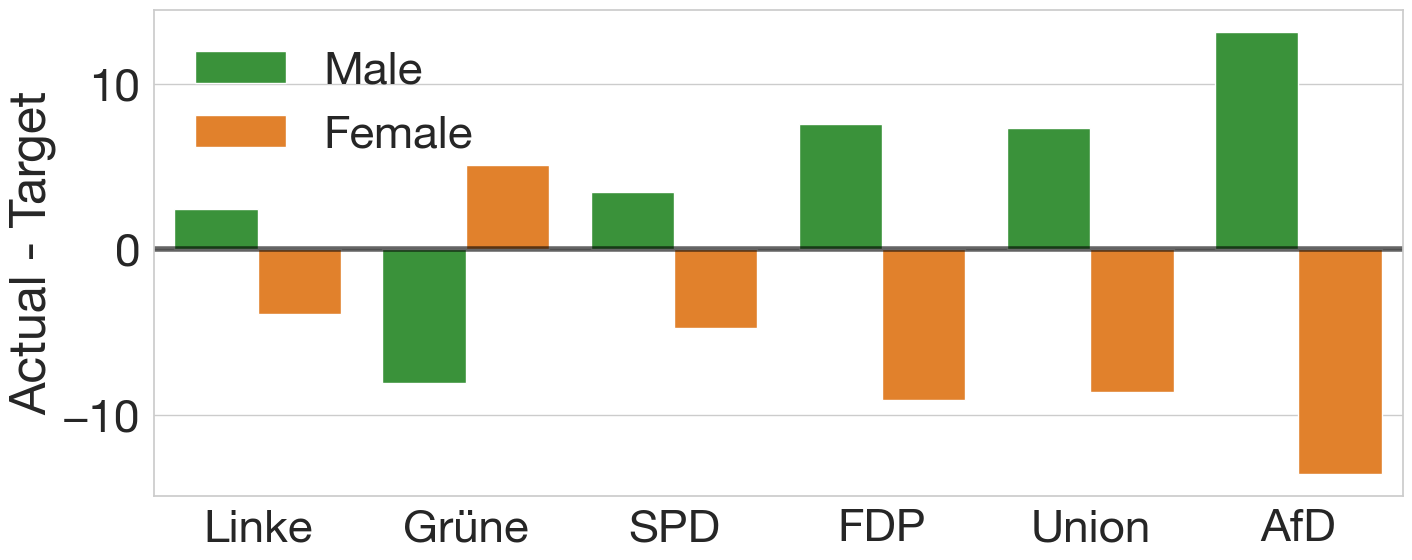

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
actual_male_values = []
target_male_values = []
actual_female_values = []
target_female_values = []

male_diff_values = []
female_diff_values = []

for ix in party_order:
   data = df[df.party == ix]
   # data = data[data["gender_distribution_distance"].notna()]
   data = data[data["female"] != "False"]

   actual_gender_distribution_sum, targeting_gender_distribution_sum = extract_weighted_avg_gender_distributions(data)

   target = targeting_gender_distribution_sum
   actual = actual_gender_distribution_sum

   y1 = np.array(list(actual.values()))
   y2 = np.array(list(target.values()))

   ws = ss.wasserstein_distance(y1*100, y2*100) 

   print(ix)
   print(ws)

   male_diff_values.append(actual["male"] - target["male"])
   female_diff_values.append(actual["female"] - target["female"])


   actual_male_values.append(actual["male"])
   target_male_values.append(target["male"])

   actual_female_values.append(actual["female"])
   target_female_values.append(target["female"])

plot_df = pd.DataFrame()
plot_df["value"] = male_diff_values + female_diff_values
plot_df["value"] *= 100
plot_df["hue"] = ["Male" for j in range(6)] + ["Female" for j in range(6)]
plot_df["party"] = [party_labels[p] for p in party_order] + [party_labels[p] for p in party_order]

sns.barplot(ax=ax, x="party", palette={"Female":"tab:orange", "Male":"tab:green"}, y="value", hue="hue", data=plot_df)

plt.tight_layout()
plt.ylabel("Actual - Target")
plt.xlabel("")
plt.axhline(0, alpha=.6, ls="-", color="black", linewidth=4)

plt.legend(frameon=False)

fig.savefig(path_figures + "parties_gender_difference.pdf")


## Regression analysis

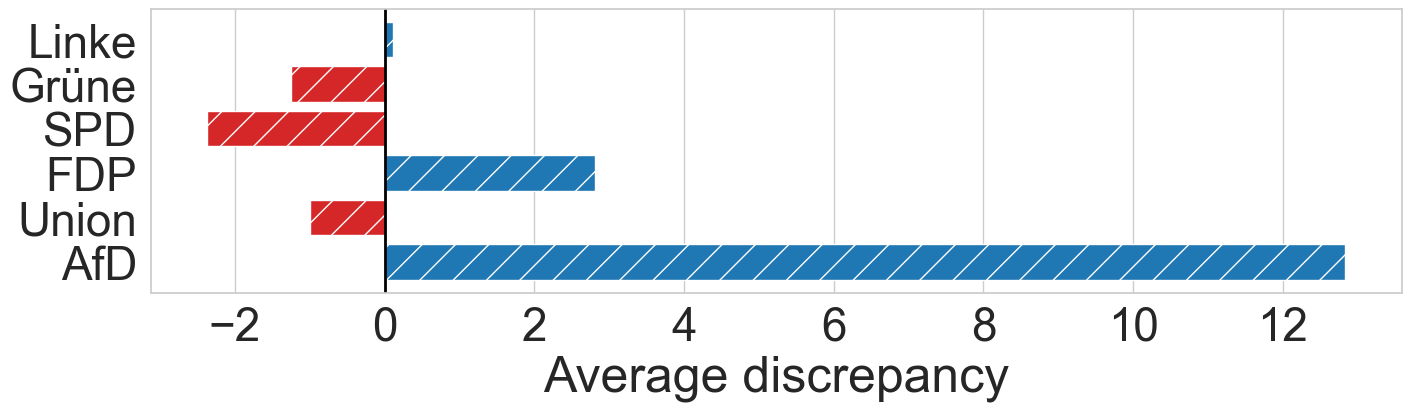

In [130]:
data = pkl.load(open("residuals_plot.pkl", "rb"))
# data["residuals"] = data["residuals"].astype(float)

# values = np.array([np.mean(data[data["party"] == p]["residuals"]) for p in party_order])[::-1]
# std = np.array([ss.sem(data[data["party"] == p]["residuals"]) for p in party_order])[::-1]

values = [data[data["party"] == p]["residuals_avg"].values[0] for p in party_order][::-1]

categories = party_order[::-1]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot the horizontal bars
bars = ax.barh(categories, values, color=['tab:red' if val < 0 else 'tab:blue' for val in values], hatch="/")

# ax.errorbar(values, range(values.__len__()), xerr=std, color='grey', ls="", alpha=0.5, linewidth=4)
# ax.scatter(values, range(values.__len__()), color=[party_pal[p] for p in party_order], 
#           ls="", marker="o", s=58)


# Set the x-axis limits to center the bars at 0
# ax.set_xlim(-max(abs(values)) - 1, max(abs(values)) + 1)

# Customize the plot
ax.set_xlabel('Average discrepancy')
ax.set_ylabel('')

# Add vertical grid lines
ax.grid(axis='y')

# Add a zero line
ax.axvline(0, color='black', linewidth=2)
plt.yticks(ticks=[0, 1, 2, 3, 4, 5][::-1], labels=party_labels.values())

# plt.legend(frameon=False, loc="upper left", fontsize=26)
plt.tight_layout()

plt.savefig(path_figures+ "avg_ml_discrepancy.pdf")

In [87]:
labels = dict()

labels["OLS_ads.pkl"] = ["Candidate Page", "Only Facebook", "Only Instagram", 
                     "FDP", "Union", "SPD", "Gruene", "Linke",
                     "Duration", 
                     "Sunday (start)", "Saturday (start)",  "Friday (start)",  
                     "Thursday (start)", "Wednesday (start)", "Tuesday (start)",
                     "Negative Sentiment", "Positive Sentiment"]

labels["OLS_demographic.pkl"] = ["Age: 65+", "Age: 55-64", "Age: 45-54",
                                 "Age: 35-44", "Age: 25-34", "Age: 18-24", "Female (only)", "Male (only)"]

labels["OLS_targeting.pkl"] = [
    "Location (Exclude)", "Employers (Exclude)", 
    "Lookalike Audience (Exclude)",  "Behaviors (Exclude)",
      "Custom Audience (Exclude)",  "Interests (Exclude)", 
    "Lookalike Audience (Include)", "Behaviors (Include)", "Custom Audience (Include)", "Interests (Include)",
     "No. Exclude Criteria", "No. Include Criteria" ]


In [88]:
params_dfs = []
for file in  ["OLS_targeting.pkl", "OLS_demographic.pkl", "OLS_ads.pkl"]:
    
    params_df = pd.DataFrame()
    res = pd.read_pickle(file)
    names = res.params.index[1:].values
    betas = np.array(res.params[1:].values)
    se = np.array(res.bse[1:].values)
    pvalues = np.array(res.pvalues[1:].values)

    params_df["name"] = names
    params_df["beta"] = betas
    params_df["se"] = se
    params_df["pval"] = pvalues
    params_df["file"] = [file for j in range(params_df.__len__())]

    params_dfs.append(params_df)

params_dfs = pd.concat(params_dfs)

In [89]:
label_mapping = {
 "interests_exclude_use_1[T.True]" : "Interests (Exclude)",
"interests_include_use_1[T.True]" : "Interests (Include)",
"employers_exclude_use_1[T.True]" : "Employers (Exclude)",
"exclude_location_1[T.True]" : "Location (Exclude)",
"behaviors_exclude_use_1[T.True]" : "Behaviors (Exclude)",
"include_lookalike_1[T.True]" : "Lookalike Audience (Include)",
"exclude_custom_audience_1[T.True]" : "Custom Audience (Exclude)",
"include_custom_audience_1[T.True]" : "Custom Audience (Include)",
"behaviors_include_use_1[T.True]" : "Behaviors (Include)",
"exclude_lookalike_1[T.True]" : "Lookalike Audience (Exclude)",
"include_count_std" : "No. Include Criteria",
"exclude_count_std" : "No. Exclude Criteria",
'targeting_gender_Men[T.True]' : "Male (only)",
'targeting_gender_Women[T.True]' : "Female (only)",
"targeting_18_24_std" : "Age: 18-24",
"targeting_25_34_std" : "Age: 25-34",
"targeting_35_44_std" : "Age: 35-44",
"targeting_45_54_std" : "Age: 45-54",
"targeting_55_64_std" : "Age: 55-64",
"targeting_65_std" : "Age: 65+",
"weekday_start_1[T.True]" : "Tuesday (start)",
"weekday_start_2[T.True]" : "Wednesday (start)",
"weekday_start_3[T.True]" : "Thursday (start)",
"weekday_start_4[T.True]" : "Friday (start)",
"weekday_start_5[T.True]" : "Saturday (start)",
"weekday_start_6[T.True]" : "Sunday (start)",
"party_fdp[T.True]" : "FDP",
"party_gruene[T.True]" : "Gruene",
"party_linke[T.True]" : "Linke",
"party_spd[T.True]" : "SPD",
"party_union[T.True]" : "Union",
"sentiment_class_positive[T.True]": "Positive Sentiment",
"sentiment_class_negative[T.True]": "Negative Sentiment",
"platform_1[T.True]" : "Only Facebook",
"platform_2[T.True]" : "Only Instagram",
"candidate_page_1[T.True]" : "Candidate Page",
"ad_duration_std" : "Duration", 
}

In [90]:
params_dfs["label"] = [label_mapping[name] for name in params_dfs["name"]]

N = 79643.0
R2 = 0.15371573421038487
R2 adj = 0.15353505185536542
MSE = 18388501.398105875
N = 79643.0
R2 = 0.15371573421038487
R2 adj = 0.15353505185536542
MSE = 18388501.398105875


/var/folders/b1/rdb8b9050b5_6qc4tjvfdpc80000gn/T/ipykernel_43571/2508444655.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/b1/rdb8b9050b5_6qc4tjvfdpc80000gn/T/ipykernel_43571/2508444655.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


N = 79643.0
R2 = 0.15371573421038487
R2 adj = 0.15353505185536542
MSE = 18388501.398105875


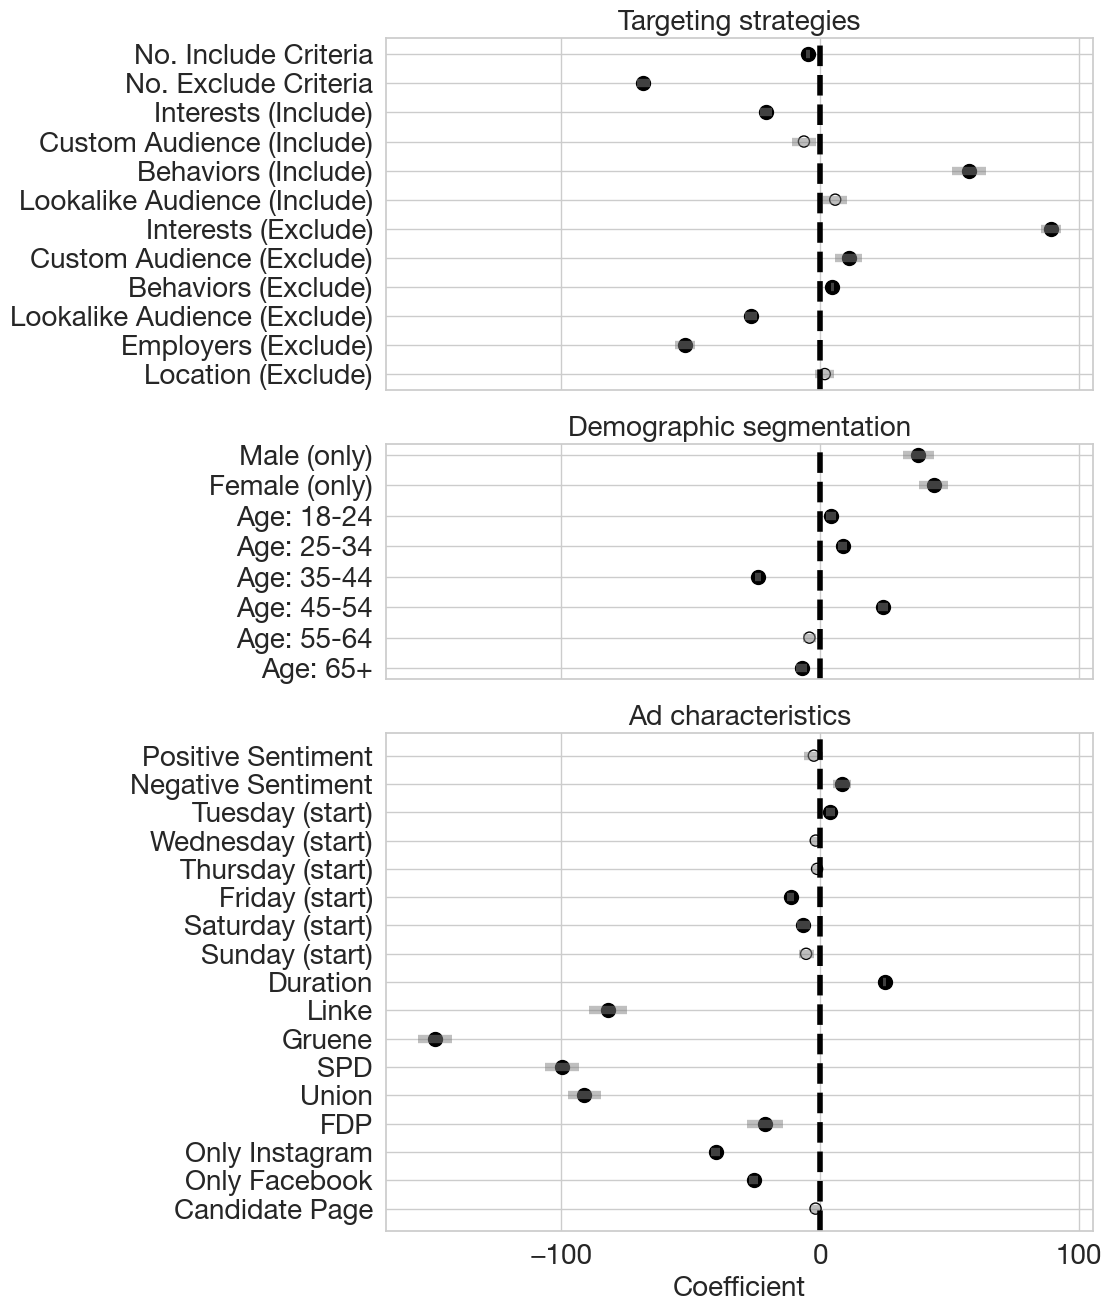

In [91]:
# Plot regression coefficients
orient = "y"

i = 0

fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'height_ratios': [12/37, 8/37, 17/37]}, figsize=(12, 14))

titles = ["Targeting strategies", "Demographic segmentation", "Ad characteristics"]


for file in  ["OLS_targeting.pkl", "OLS_demographic.pkl", "OLS_ads.pkl"]:
    
    betas = np.array(params_dfs[params_dfs["file"] == file]["beta"].values)
    se = np.array(params_dfs[params_dfs["file"] == file]["se"].values)
    pvalues = np.array(params_dfs[params_dfs["file"] == file]["pval"].values)

    label_order = labels[file]
    yticks = params_dfs[params_dfs["file"] == file]["label"].values

    L = yticks.__len__()

    ixs = []
    for ix in range(L):
        for j in range(L):
            if yticks[j] == label_order[ix]:
                ixs.append(j)
                break
    
    yticks = yticks[ixs]
    betas = betas[ixs]
    se = se[ixs]
    pvalues = pvalues[ixs]


    ax = axs[i]

    if orient == "x":


        ax.scatter(range(L), betas,facecolor="none", edgecolor="black", marker="o", s=64)
            
        # mask = [i for i in range(L) if pvalues[i] <= 0.1]
        # ax.scatter(mask, betas[pvalues <= 0.1], color="tab:green", s=64)

        mask = [m for m in range(L) if pvalues[m] <= 0.05]
        ax.scatter(mask, betas[pvalues <= 0.05], color="black", s=100)

        ax.errorbar(range(L), betas, yerr=se, color='grey', ls="", alpha=0.5, linewidth=6)
        ax.axhline(0, color="black", ls="--", linewidth=4)
        ax.set_xticks(range(L), labels[file], rotation=90, fontsize=26)
    else:


        ax.scatter(betas, range(L), facecolor="none", edgecolor="black", marker="o", s=64)
            
        # mask = [i for i in range(L) if pvalues[i] <= 0.1]
        # ax.scatter(mask, betas[pvalues <= 0.1], color="tab:green", s=64)

        mask = [m for m in range(L) if pvalues[m] <= 0.05]
        ax.scatter(betas[pvalues <= 0.05], mask, color="black",  s=100)

        ax.errorbar(betas, range(L), xerr=se, color='grey', ls="", alpha=0.5, linewidth=6)
        ax.axvline(0, color="black", ls="--", linewidth=4)
        ax.set_yticks(range(L), yticks, fontsize=20)    

        plt.xticks(fontsize=20)
        # ax.yaxis.grid(False)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.15)
    # print(res.summary())   # Summarize model

    print("N = "+str(res.nobs))
    print("R2 = "+str(res.rsquared))
    print("R2 adj = "+str(res.rsquared_adj))
    print("MSE = "+str(res.mse_model))

    #ax.text(-0.45, 1, letters[i], transform=ax.transAxes, 
    #        size=26, fontstyle="normal", fontweight='extra bold')
    
    ax.set_title(titles[i], fontsize=20)
    
    i += 1
    plt.xlabel("Coefficient", fontsize=20)

    
    fig.savefig(path_figures + "ols_results.pdf")


## Supplementary Figures 

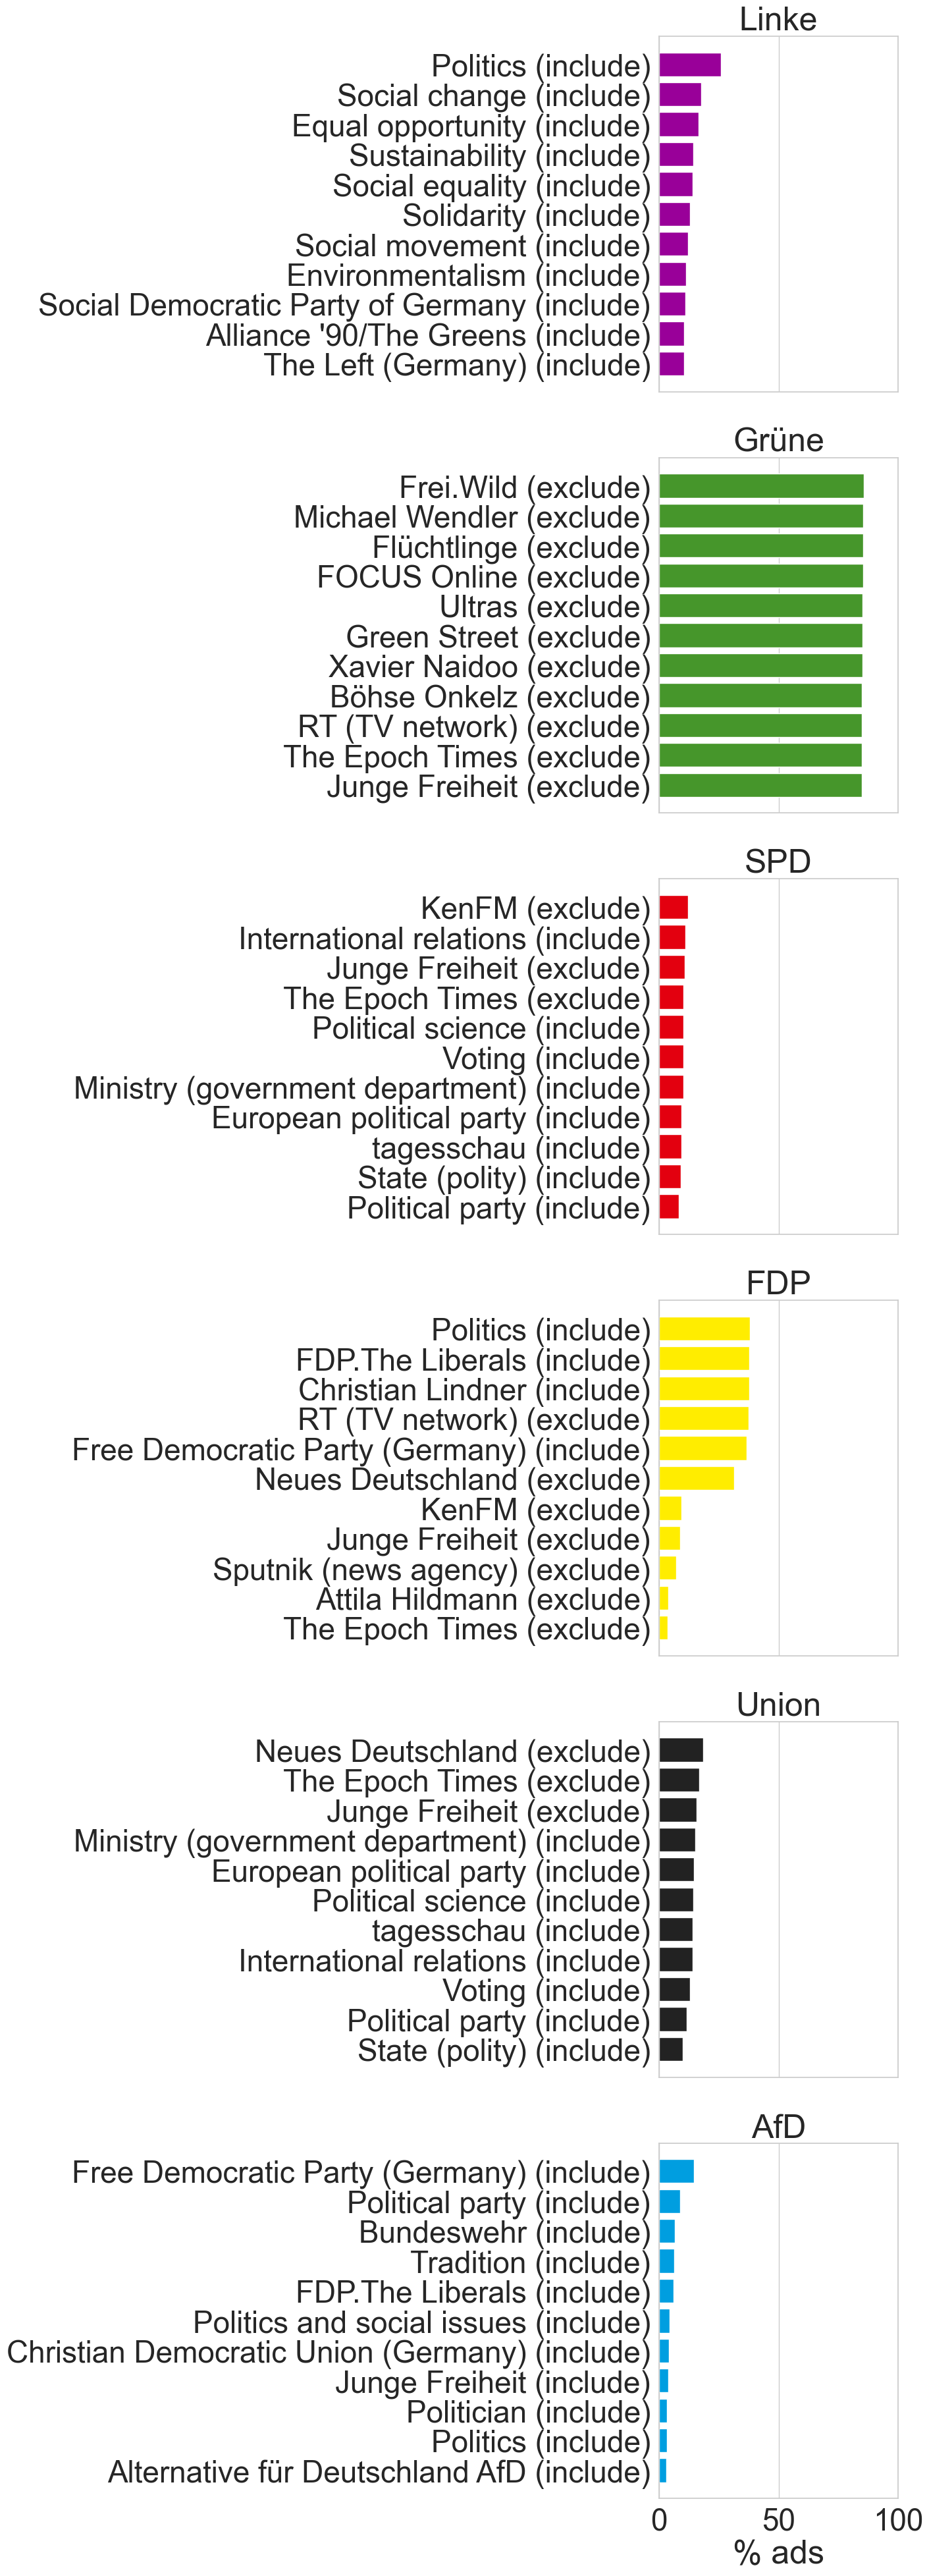

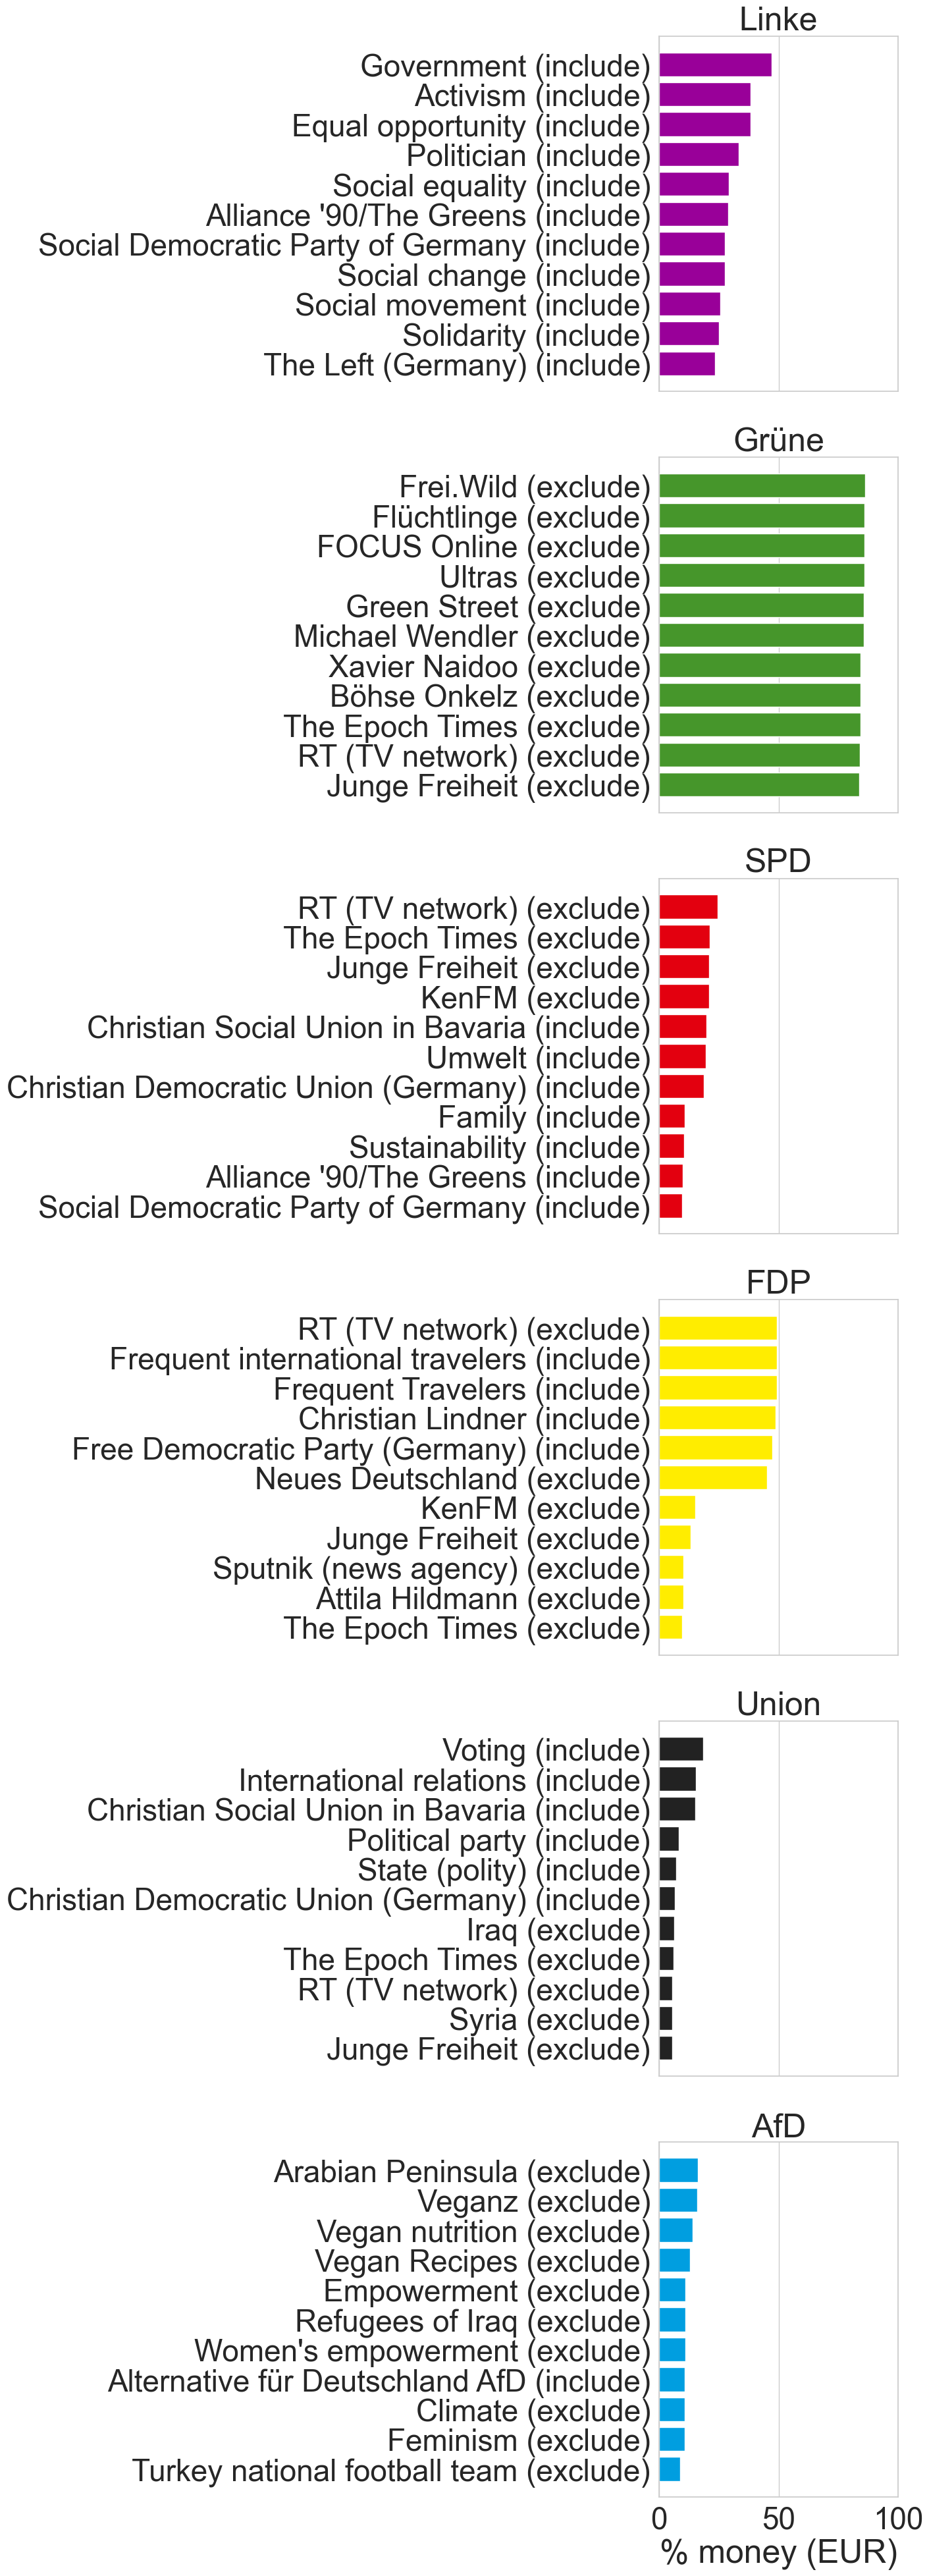

In [77]:
sns.set(style="whitegrid", font_scale=3)
for count, label in zip([target_options_counter, target_options_money_counter], ["% ads", "% money"]):
    # Set up the plot
    fig, axs = plt.subplots(6,1, sharex=True, figsize=(15, 40))

    j = 0
    for party in party_order:
        
        ax = axs[j]
        
        j += 1
        
        
        # Sample data
        # categories, values = zip(*count[party].most_common(5))
        categories = []
        values = []
        for c in count[party].most_common():
            if "_include" not in c[0] and "_exclude" not in c[0]:
                continue
            if categories.__len__() > 10:
                break
            categories.append(c[0].replace("_include", " (include)").replace("_exclude", " (exclude)").encode('latin'))
            values.append(c[1])

        if label == "% ads":
            total = df[df["party"] == party].__len__()
        else:
            total = df[df["party"] == party]["spend"].sum()
        values = np.array(values)/total * 100
        
        # Plot the horizontal bars
        bars = ax.barh(categories, values[::-1], color=party_pal[party])

        ax.set_ylabel('')

        # Add vertical grid lines
        ax.grid(axis='y')
        ax.set_title(party_labels[party])
        ax.set_xlim(0, 100)
        
        if j == 6:
            ax.set_xlabel(label.replace("% money", "% money (EUR)"))
        
    plt.tight_layout()
    if label == "% money":
        plt.savefig(path_figures + "top-10-criteria-parties.pdf")

In [78]:
number_categories_counter = defaultdict(list)

categories = [c for c in targeting_columns if "use" in c]


for ix, row in df.iterrows():
    money = row["spend"]
    party = row["party"]
    no_categories = 0
    for c in categories:
        if row[c] != 0:
            no_categories += 1
    if not row["Targeting"]:
        continue
    number_categories_counter[party].append(no_categories)

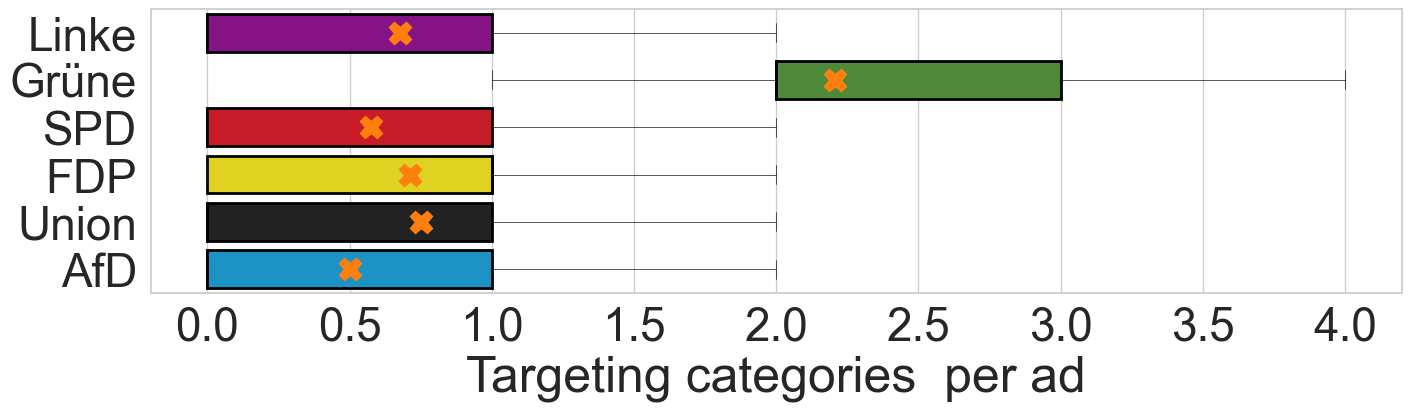

In [79]:
plt.figure(figsize=(15, 5))

plot_df = []
for party in number_categories_counter:
    d = pd.DataFrame()
    d["value"] = number_categories_counter[party]
    d["party"] = [party for j in range(d.__len__())]
    plot_df.append(d)
plot_df = pd.concat(plot_df)

# Boxplot
sns.boxplot(data=plot_df, x="value", y="party", showmeans=True, showfliers = False,
            linewidth=0.5, 
            palette=party_pal, order=party_order,
            meanprops={"marker":"X",
                       "markerfacecolor":"tab:orange", 
                       "markeredgecolor":"tab:orange",
                       "markersize":"16"},           
            medianprops={'linewidth':2, 'color':'black'},
            boxprops = {"linewidth":2, 'edgecolor':'black'})

plt.yticks(ticks=[0, 1, 2, 3, 4, 5], labels=party_labels.values())
plt.xlabel("Targeting categories  per ad")
plt.ylabel("")
plt.tight_layout()
plt.savefig(path_figures + "targeting_categories_length.pdf")
plt.show()



## Top criteria based on regression 

In [80]:
variable = "interests_exclude"

In [81]:
df[df[variable+"_use"] == 0]["impressions_per_spending"].describe()

count    40404.000000
mean       117.914813
std        177.629408
min         10.022556
25%         10.090909
50%         70.696970
75%        131.303030
max       8080.797980
Name: impressions_per_spending, dtype: float64

In [82]:
df[df[variable+"_use"] == 1]["impressions_per_spending"].describe()

count    41145.000000
mean        55.657084
std        131.634887
min         10.001800
25%         10.090909
50%         10.090909
75%         40.393939
max       2525.242424
Name: impressions_per_spending, dtype: float64

In [83]:
data = df[df[variable] != "False"]
data[variable] = [eval(e) for e in data[variable]]
data = data.explode(variable)
data.groupby(variable).count().reset_index().sort_values("13-17", ascending=False).head(20)

/var/folders/b1/rdb8b9050b5_6qc4tjvfdpc80000gn/T/ipykernel_90100/3646453423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[variable] = [eval(e) for e in data[variable]]


interests_exclude  13-17  18-24  25-34  35-44  45-54  55-64    65+  \
169           Junge Freiheit  40106  40106  40106  40106  40106  40106  40106   
283          The Epoch Times  39862  39862  39862  39862  39862  39862  39862   
171                    KenFM  38448  38448  38448  38448  38448  38448  38448   
18           Attila Hildmann  37101  37101  37101  37101  37101  37101  37101   
245          RT (TV network)  35251  35251  35251  35251  35251  35251  35251   
117                Frei.Wild  33324  33324  33324  33324  33324  33324  33324   
43             BÃ¶hse Onkelz  33168  33168  33168  33168  33168  33168  33168   
311            Xavier Naidoo  33071  33071  33071  33071  33071  33071  33071   
284  The Patriot (2000 film)  32946  32946  32946  32946  32946  32946  32946   
133             Green Street  32905  32905  32905  32905  32905  32905  32905   
97              FOCUS Online  32843  32843  32843  32843  32843  32843  32843   
109             FlÃ¼chtlinge  32842  32842  32842  32842  32842  32842  32842   
292                   Ultras  32824  32824  32824  32824  32824  32824  32824   
198          Michael Wendler  32812  32812  32812  32812  32812  32812  32812   
17                      Army  32659  32659  32659  32659  32659  32659  32659   
258                   Russia  32600  32600  32600  32600  32600  32600  32600   
210                NPD Group  32600  32600  32600  32600  32600  32600  32600   
126              German Army  32559  32559  32559  32559  32559  32559  32559   
40                Bundeswehr  32501  32501  32501  32501  32501  32501  32501   
28                Autotuning  32471  32471  32471  32471  32471  32471  32471   

     ad_creation_time  ad_creative_bodies  ...  total_count  \
169             40106               40106  ...        40106   
283             39862               39862  ...        39862   
171             38448               38448  ...        38448   
18              37101               37101  ...        37101   
245             35251               35251  ...        35251   
117             33324               33324  ...        33324   
43              33168               33168  ...        33168   
311             33071               33071  ...        33071   
284             32946               32946  ...        32946   
133             32905               32905  ...        32905   
97              32843               32843  ...        32843   
109             32842               32842  ...        32842   
292             32824               32824  ...        32824   
198             32812               32812  ...        32812   
17              32659               32659  ...        32659   
258             32600               32600  ...        32600   
210             32600               32600  ...        32600   
126             32559               32559  ...        32559   
40              32501               32501  ...        32501   
28              32471               32471  ...        32471   

     targeting_gender_distribution  actual_age_distribution  \
169                          40106                    40106   
283                          39862                    39862   
171                          38448                    38448   
18                           37101                    37101   
245                          35251                    35251   
117                          33324                    33324   
43                           33168                    33168   
311                          33071                    33071   
284                          32946                    32946   
133                          32905                    32905   
97                           32843                    32843   
109                          32842                    32842   
292                          32824                    32824   
198                          32812                    32812   
17                           32659      

In [5]:
df[df["behaviors_include"] != "False"]["behaviors_include"].unique()

array(["['Commuters']",
       "['Family of those who live abroad', 'Friends of those who live abroad', 'Lives abroad']",
       "['Family of those who live abroad', 'Friends of those who live abroad', 'Lived in France (Formerly Expats - France)', 'Lives abroad']",
       "['Small business owners']", "['Frequent Travelers']",
       "['Frequent international travelers']",
       "['Facebook access (OS): Mac OS X', 'Facebook access (OS): Mac Sierra', 'Facebook access (OS): Windows 10', 'Facebook access (OS): Windows 7', 'Facebook access (OS): Windows 8', 'Facebook access (OS): Windows Vista', 'Facebook access (browser): Chrome', 'Facebook access (browser): Firefox', 'Facebook access (browser): Internet Explorer', 'Facebook access (browser): Microsoft Edge', 'Facebook access (browser): Opera', 'Facebook access (browser): Safari', 'Facebook access: older devices and OS', 'Interested in Upcoming Events', 'People who have visited Facebook Gaming', 'Small business owners', 'Technology early 

In [84]:
df[df["employers_include"] != "False"]["employers_include"].unique()

array(["['SelbststÃ¤ndig']", "['Urlaub']", "['Ã\\x96ffentlicher Dienst']",
       "['Progressive']", "['Meio ambiente [Employers]']",
       "['CDU/CSU-Bundestagsfraktion']",
       "['Bundeswehr', 'CDU/CSU-Bundestagsfraktion']",
       "['CDU/CSU-Bundestagsfraktion', 'Deutsche Telekom AG']", "['SPD']",
       "['CDU/CSU-Bundestagsfraktion', 'GameStop', 'SPD', 'UNIVERSITÃ\\x84T LEIPZIG']",
       "['France 3 [Employers]', 'SNCF Voyageurs']",
       "['CDU/CSU-Bundestagsfraktion', 'SPD']",
       "['Legalize Marijuana [Employers]']",
       "['Environmentalism [Employers]']", "['Bundeswehr']",
       "['Deutsche Bundesbank', 'Frankfurt Airport', 'Goethe-UniversitÃ¤t Frankfurt [Employers]', 'SelbststÃ¤ndig']",
       "['Greenpeace International', 'Otto-von-Guericke-UniversitÃ¤t Magdeburg', 'Uni Halle']",
       "['Rentner']", "['Online-Marketing']",
       "['Business Owner [Employers]']",
       "['Frankfurt Airport [Employers]']",
       "['BMW', 'BMW Deutschland', 'Mercedes-Benz', 'Po

In [164]:
df[df["id"] == 386575689537277]["interests_exclude"].values[0]

"['Boehringer Ingelheim', 'BÃ¶se Buben Club', 'Deutsch lernen', 'Frei.Wild', 'Junge Freiheit', 'KenFM', 'Kompakt', 'Language interpretation', 'NachDenkSeiten', 'RT (TV network)', 'The Epoch Times', 'The Patriot (2000 film)', 'Translation']"

In [173]:
line

[b'Boehringer Ingelheim',
 b'B\xc3\xb6se Buben Club',
 b'Deutsch lernen',
 b'Frei.Wild',
 b'Junge Freiheit',
 b'KenFM',
 b'Kompakt',
 b'Language interpretation',
 b'NachDenkSeiten',
 b'RT (TV network)',
 b'The Epoch Times',
 b'The Patriot (2000 film)',
 b'Translation']

In [177]:
line = []
for i in eval(df[df["id"] == 386575689537277]["interests_exclude"].values[0]):
    print(i.encode("latin").decode("latin"))


Boehringer Ingelheim
BÃ¶se Buben Club
Deutsch lernen
Frei.Wild
Junge Freiheit
KenFM
Kompakt
Language interpretation
NachDenkSeiten
RT (TV network)
The Epoch Times
The Patriot (2000 film)
Translation


In [178]:
df[df["id"] == 386575689537277]["interests_exclude"].values[0]

"['Boehringer Ingelheim', 'BÃ¶se Buben Club', 'Deutsch lernen', 'Frei.Wild', 'Junge Freiheit', 'KenFM', 'Kompakt', 'Language interpretation', 'NachDenkSeiten', 'RT (TV network)', 'The Epoch Times', 'The Patriot (2000 film)', 'Translation']"